<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Fractional and Volterra processes in Finance  </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Challenge 1 -  Simulation of Gaussian Volterra processes </strong></p>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> Challenge : Unlock the potential of Gaussian fractional processes and pave the way for more accurate simulations! </strong></p>

The aim of the challenge is to figure out ways to efficiently simulate the Riemann-Liouville fractional Brownian motion:
$$  X_t = \nu  \int_0^t  K(t,s) dW_s, $$
with
$$ K(t,s) = \frac{1}{\Gamma(H + 1/2)} (t - s)^{H-1/2} 1_{s<t}$$
and $H<1/2$.

The covariance kernel of $X$ is given in the following closed form
\begin{align}
\Sigma_0(s,u)&=\frac{\nu^2}{\Gamma(H+1/2)^2}\int_0^{s\wedge u} (s-z)^{H-1/2}(u-z)^{H-1/2}dz\\
&=\frac{\nu^2}{\Gamma(\alpha)\Gamma(1+\alpha)}\frac{s^{\alpha}}{u^{1-\alpha}} \; {}_{2}F_{1}\left( 1, 1-\alpha; 1+\alpha ; \frac s u\right)
\end{align}
where $\alpha=H+1/2$ and  ${}_{2}F_{1}$ is the Gaussian hypergeometric function.

**Guidelines**
- Implement and briefly explain and comment the methods. We are interested in low regimes of $H$. Plot the sample paths on same gaussian increments, to compare paths by paths. You can take $T=1.$ and $n_{steps}=300$ time steps uniformly spaced on $[0,T]$. (set $\nu=1$).  
- Two metrics : running time (using "timeit) to simulate one trajectory and MSE error of the paths wrt to the exact path simulated using cholesky method:
$$MSE = \sqrt{\frac 1 {n_{steps}} \sum_{i=1}^{n_{steps}} \left(X^{\text{method}}_{t_i} - X^{\text{cholesky}}_{t_i}\right)^2 }   $$


**Question:** Detail the computations that lead to the covariance kernel. Is it valid for $H\leq 1/2$, $H\geq 1/2$? both?

**Answer:** ....

Several options and suggestions detailed below:
- Cholesky
- Different Euler schemes
- multifactor euler vs exact (cholesky on factors)


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Exact simulation using Cholesky</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> Warm up with Cholesky, but aim to set the simulation field on fire with your efficient methods for Gaussian fractional processes. </strong></p>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sc
from scipy.special import gamma, gammainc, hyp2f1
from scipy.integrate import quad
import scipy.integrate as it
from scipy.integrate import quad
from scipy.linalg import cholesky
from scipy.optimize import minimize
from math import log
np.random.seed(seed=42)

#increasing figure size
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.rcParams['font.family'] = "serif"

The ${}_{2}F_{1}$ Gaussian hypergeometric function can be implemented using  scipy `sc.hyp2f1`, pay close attention to the parameters, notably final parameter needs to be less than 1?

**Question:** Check the doc https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.hyp2f1.html and explain.


In [ ]:
# Paramètres

T = 1
nsteps = 300
v = 1
H = 0.14
X0 = 5

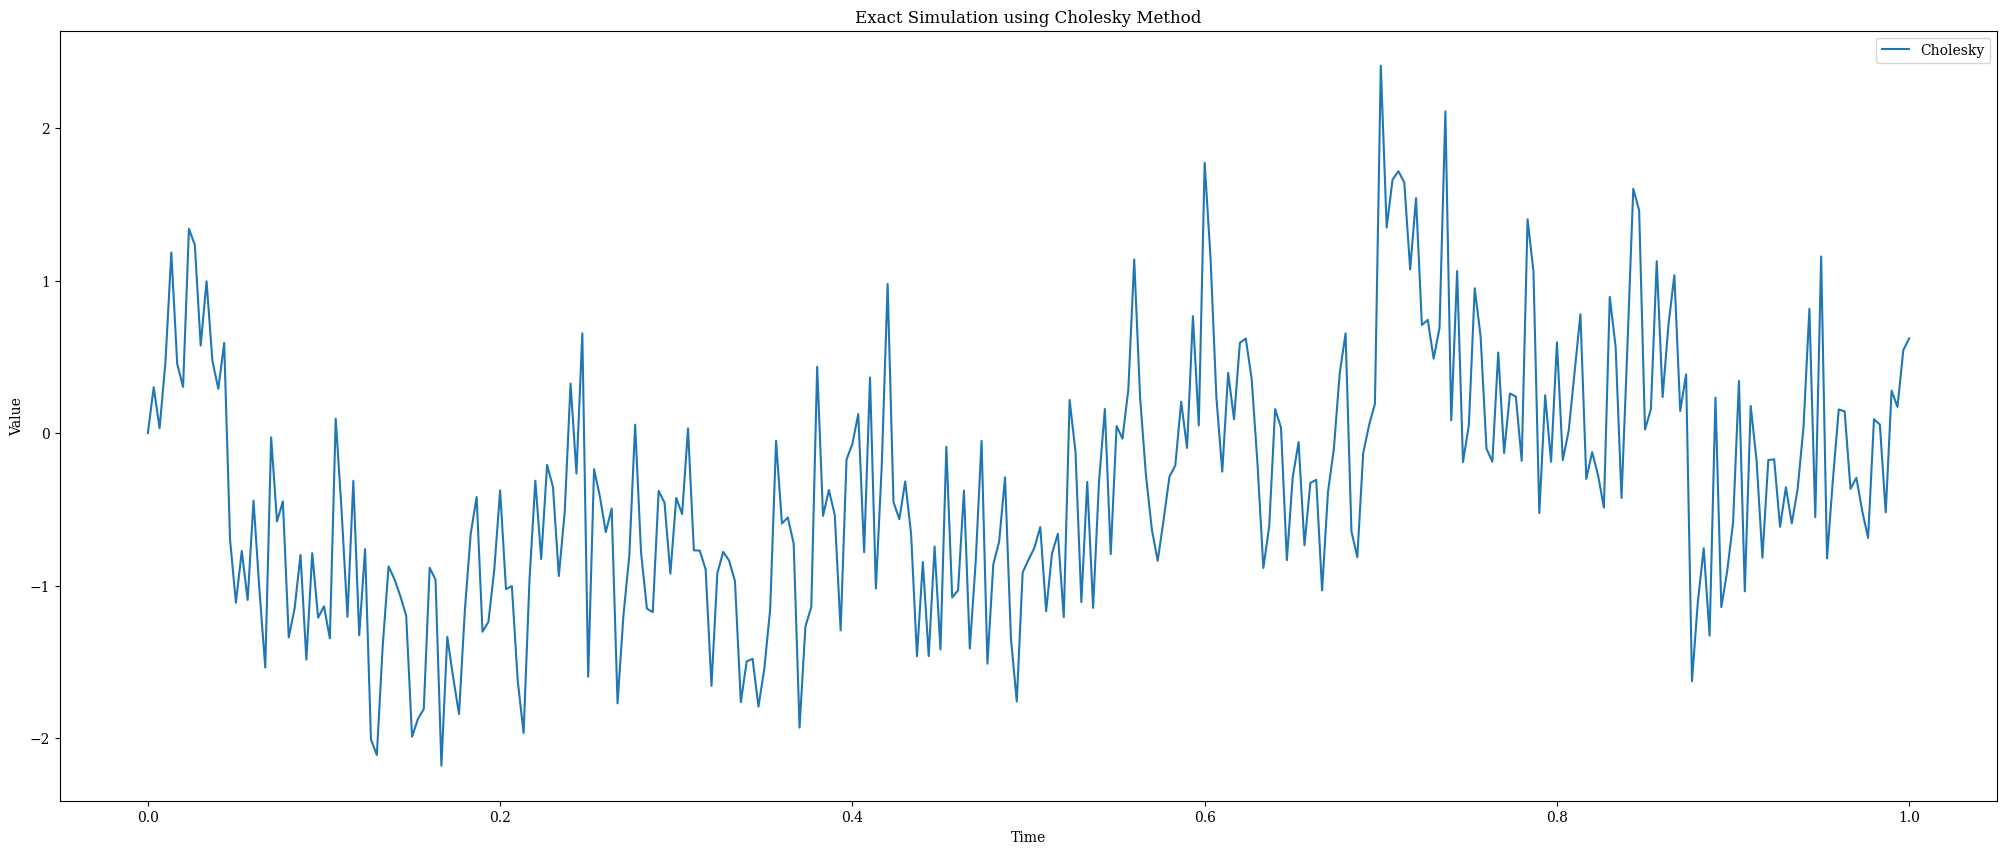

In [ ]:
# Paramètres
def K(t,s,H):
  return (((t-s)**(H-1/2))/gamma(H+1/2)) * (1 if t>s else 0)
T = 1
nsteps = 300
v = 1
H = 0.14


def cov(nu,H,s,u):
    alpha=H+0.5
    s,u = min(s,u), max(s,u)
    k=(nu**2)/(gamma(alpha)*gamma(1+alpha))*(s**alpha/u**(1-alpha))*hyp2f1(1, 1-alpha, 1+alpha, s/u)
    return k

def cholesky(nu, H, T, n_steps):
    dt = T/n_steps
    t_vec = np.linspace(dt, T, n_steps)
    cov_matrix = [[cov(nu,H,t,s) for t in t_vec] for s in t_vec]
    L = np.linalg.cholesky(cov_matrix)
    return L

def simu_cholesky(L,Z,T,n_steps):
    dt = T/n_steps
    t_vec = np.linspace(dt, T, n_steps)
    RL_path= L@Z
    return np.concatenate((np.array([0.]), RL_path)), np.concatenate((np.array([0.]), t_vec))



# Attempt to run the simulation
L = cholesky(v, H, T, nsteps)
Z = np.random.normal(0, 1, nsteps)

result = simu_cholesky(L,Z,T,nsteps)
if result is not None:
    X_cholesky, t_values = result
    plt.plot(t_values, X_cholesky, label='Cholesky')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Exact Simulation using Cholesky Method')
    plt.legend()
    plt.show()


The covariance kernel $\Sigma_0(s, u)$ is derived from the integral expression provided for $K(t, s)$. Let's break down the steps leading to the covariance kernel:

Starting with the definition of $K(t, s)$:
$K(t, s) = \frac{1}{\Gamma(H + 1/2)} (t - s)^{H-1/2} 1_{s<t}$

Now, we express the integral representation of $X_t$:
$X_t = \nu \int_0^t K(t, s) dW_s$

Next, we express the covariance kernel $\Sigma_0(s, u)$ in terms of the integral involving $K(t, s)$:
$
\Sigma_0(s, u) = \frac{\nu^2}{\Gamma(H + 1/2)^2} \int_0^{s \wedge u} (s - z)^{H-1/2} (u - z)^{H-1/2} dz $

Now, we substitute the expression for $K(t, s)$ into the integral:
$
\Sigma_0(s, u) = \frac{\nu^2}{\Gamma(\alpha)\Gamma(1+\alpha)} \frac{s^{\alpha}}{u^{1-\alpha}} {}_{2}F_{1}\left( 1, 1-\alpha; 1+\alpha ; \frac s u\right)
$

Here, $\alpha = H + 1/2$, and ${}_{2}F_{1}$ is the Gaussian hypergeometric function. This expression is valid for $H < 1/2$, as $\Gamma(\alpha)$ and $\Gamma(1+\alpha)$ do not have singularities for $H < 1/2$. However, for $H \geq 1/2$, these gamma functions may become infinite, and the expression may not be well-defined.

Regarding the $\texttt{scipy.special.hyp2f1}$ function, the documentation specifies that the final parameter should be less than 1 in magnitude. This is because the hypergeometric function ${}_{2}F_{1}(a, b; c; z)$ has a convergence radius, and for stability and convergence, the absolute value of the ratio $|z/c|$ should be less than 1. If this condition is not satisfied, the function may not converge, and the result may not be accurate.


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Euler Schemes</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> Explore the unknown and discover the hidden potential of Euler methods through a performance evaluation. </strong></p>

We will consider three (modified) Euler schemes after writing
$$ X_{t_i} = X_0 + \sum_{j=1}^i \underbrace{\int_{t_{j-1}}^{t_j} K(t_i,s) dW_s}_{Y^{i}_j}. $$

1. **EULER 1** Naive: $$ X_{t_i} = X_0 + \nu \sqrt{dt}\sum_{j=1}^i K(t_i,t_{j-1}) Z_j $$
with $Z_j \sim \mathcal N(0,1)$ iid.

2. **EULER 2** Write $dW_s \approx Z_j \frac{ds}{\sqrt{dt}}$ so that
$$ X_{t_i} = X_0 + \nu \sum_{j=1}^i w_j^i Z_j $$
with
$$ w_j^i =   \frac{1}{\sqrt{dt}}\int_{t_{j-1}}^{t_j} K(t_i,s) ds =  \int_{t_{j-1}}^{t_j} K(t_i,s) ds  =   \frac{1}{\sqrt{dt}} \frac{1}{\Gamma(H + 0.5)(H + 0.5)} \left( (t_i - t_{j-1})^{H+0.5} - (t_i - t_{j})^{H+0.5} \right)$$
3. **EULER 3** Observe that $(Y^i_1, \ldots, Y^i_i)$ is a centered Gaussian vector with independent components such that the std of the j-th component is
$$  \tilde w^i_j = \sqrt{\int_{t_{j-1}}^{t_j} K(t_i,s)^2 ds} = \frac{1}{\Gamma(H + 0.5)} \sqrt{\frac{\left( (t_i - t_{j-1})^{2H} - (t_i - t_{j})^{2H} \right)}{2H}}$$
so that we use
$$ X_{t_i} \approx X_0 + \nu \sum_{j=1}^i    \tilde w^i_j Z_j.$$
Note that the simulation is not exact since $$\mathbb E[Y_j^i Y_{j'}^{i'} ] = \int_{t_{j-1}}^{t_j} K(t_i, s) K(t_{i'},s) ds 1_{j=j'} $$,  whereas in the approximation $\mathbb E[\tilde Y_j^i \tilde Y_{j'}^{i'} ] = w^{i}_j w^{i'}_j $. ($\fbox{to double check}$)


$\textbf{Reference}$: Rambaldi, S., & Pinazza, O. (1994). An accurate fractional Brownian motion generator. Physica A: Statistical Mechanics and its Applications, 208(1), 21-30.


Compare on graphs + MSE that the Naive Euler scheme is way off for small values of $H<0.05$. Works fine for bigger values of $H>0.3$... etc...

**(!)** Please stick to the names **EULER 1**, **EULER 2**, **EULER 3**.

Example of expected graph for sample path:



<img src="images/pathsex.png" alt="Transposition of a vector" title="Vector transposition" width="400">



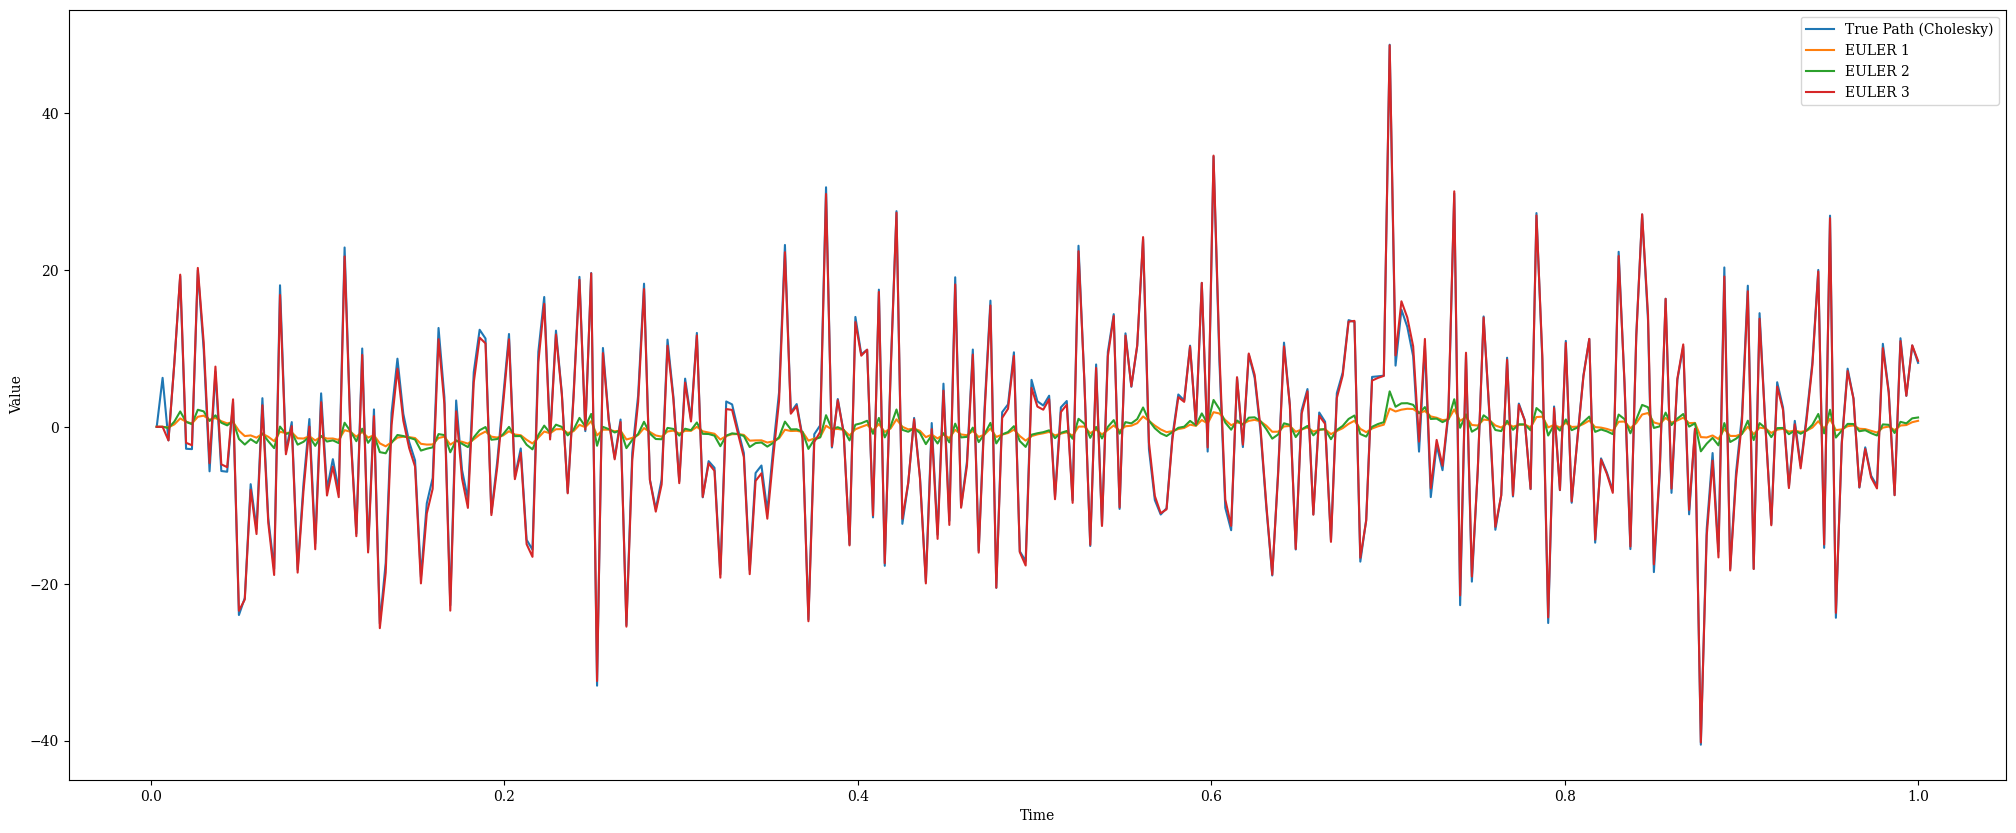

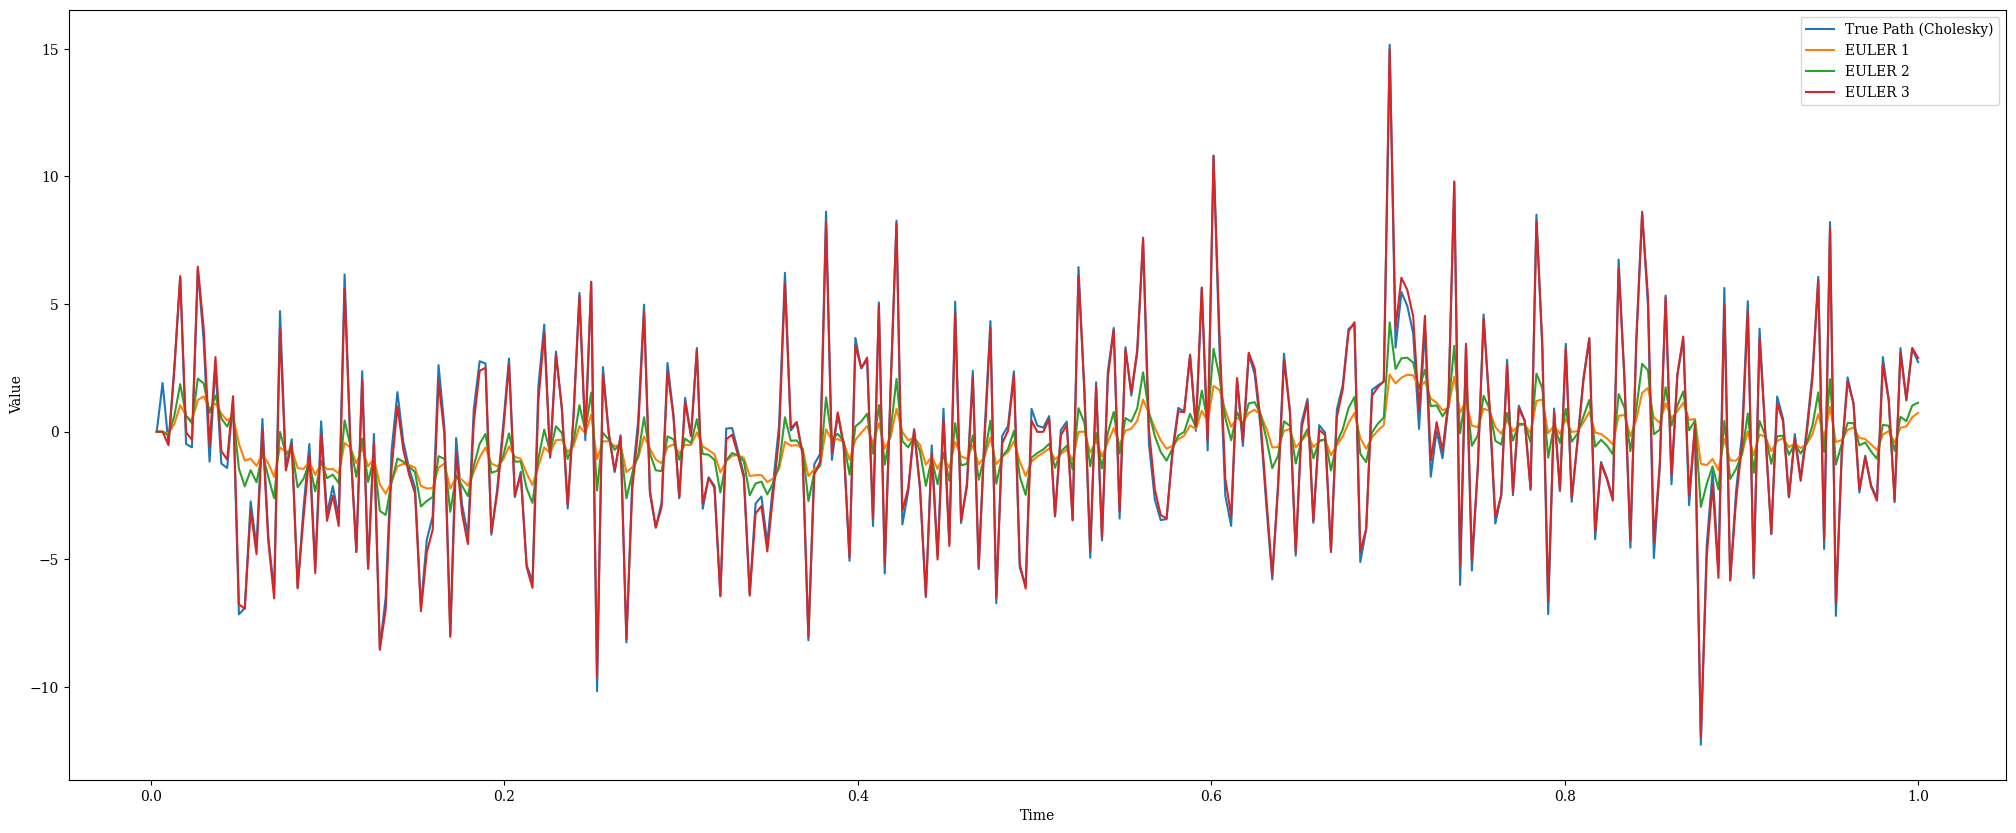

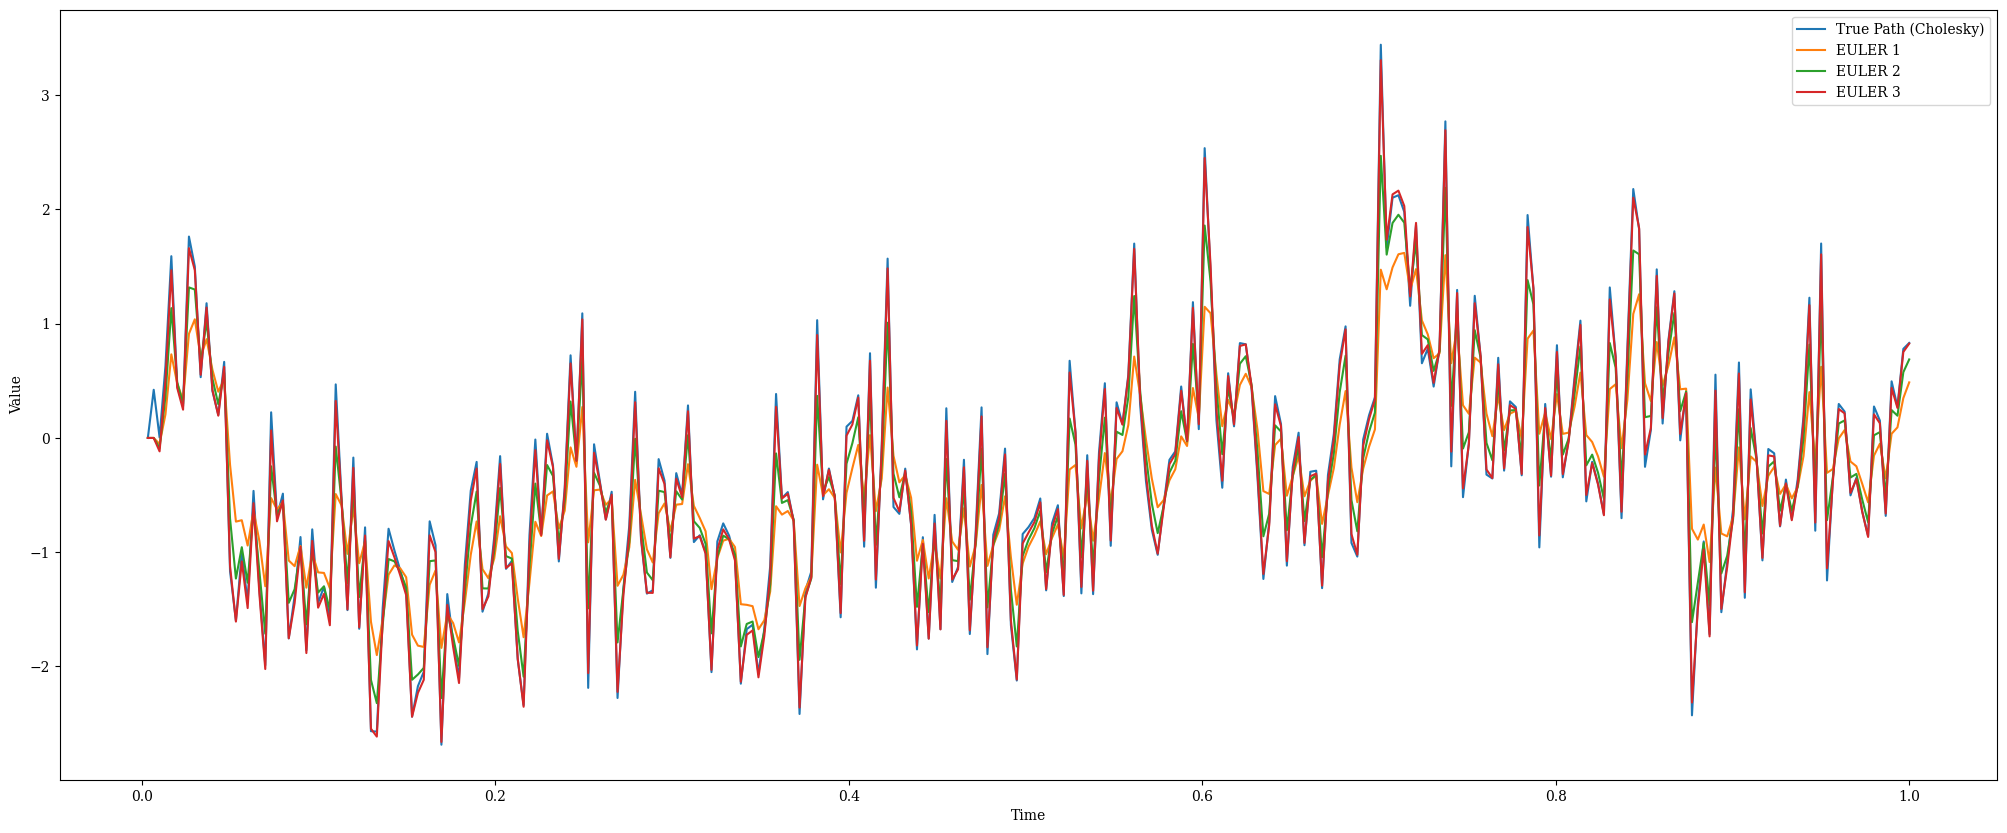

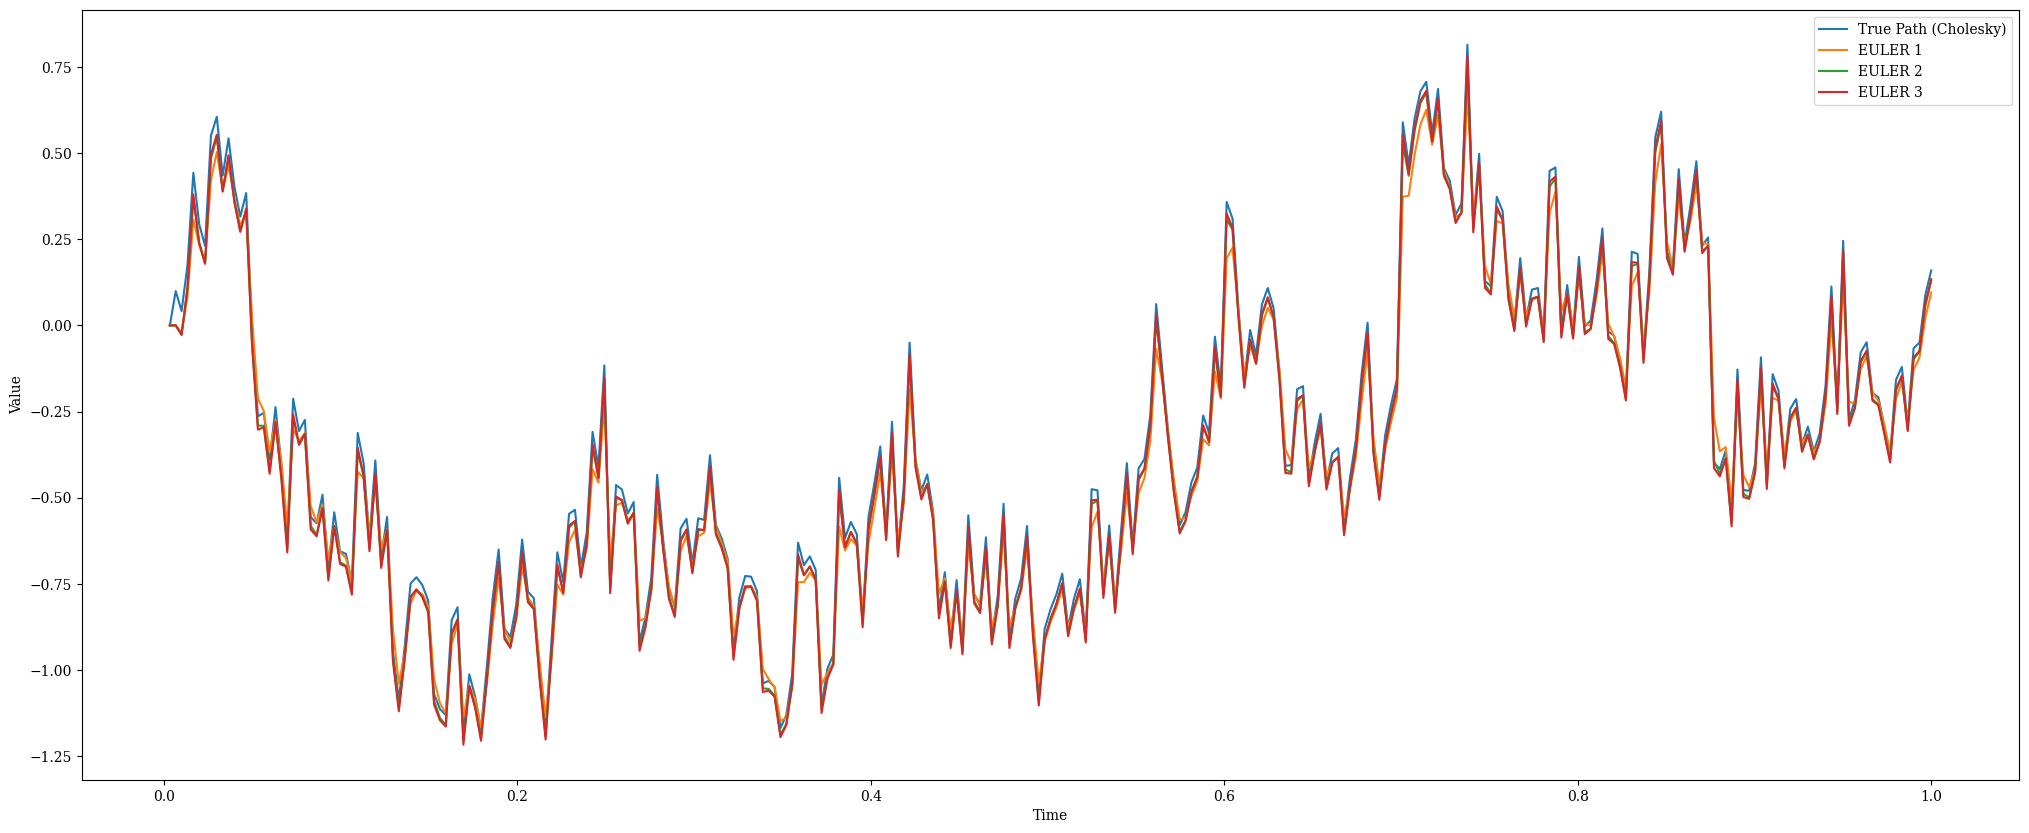

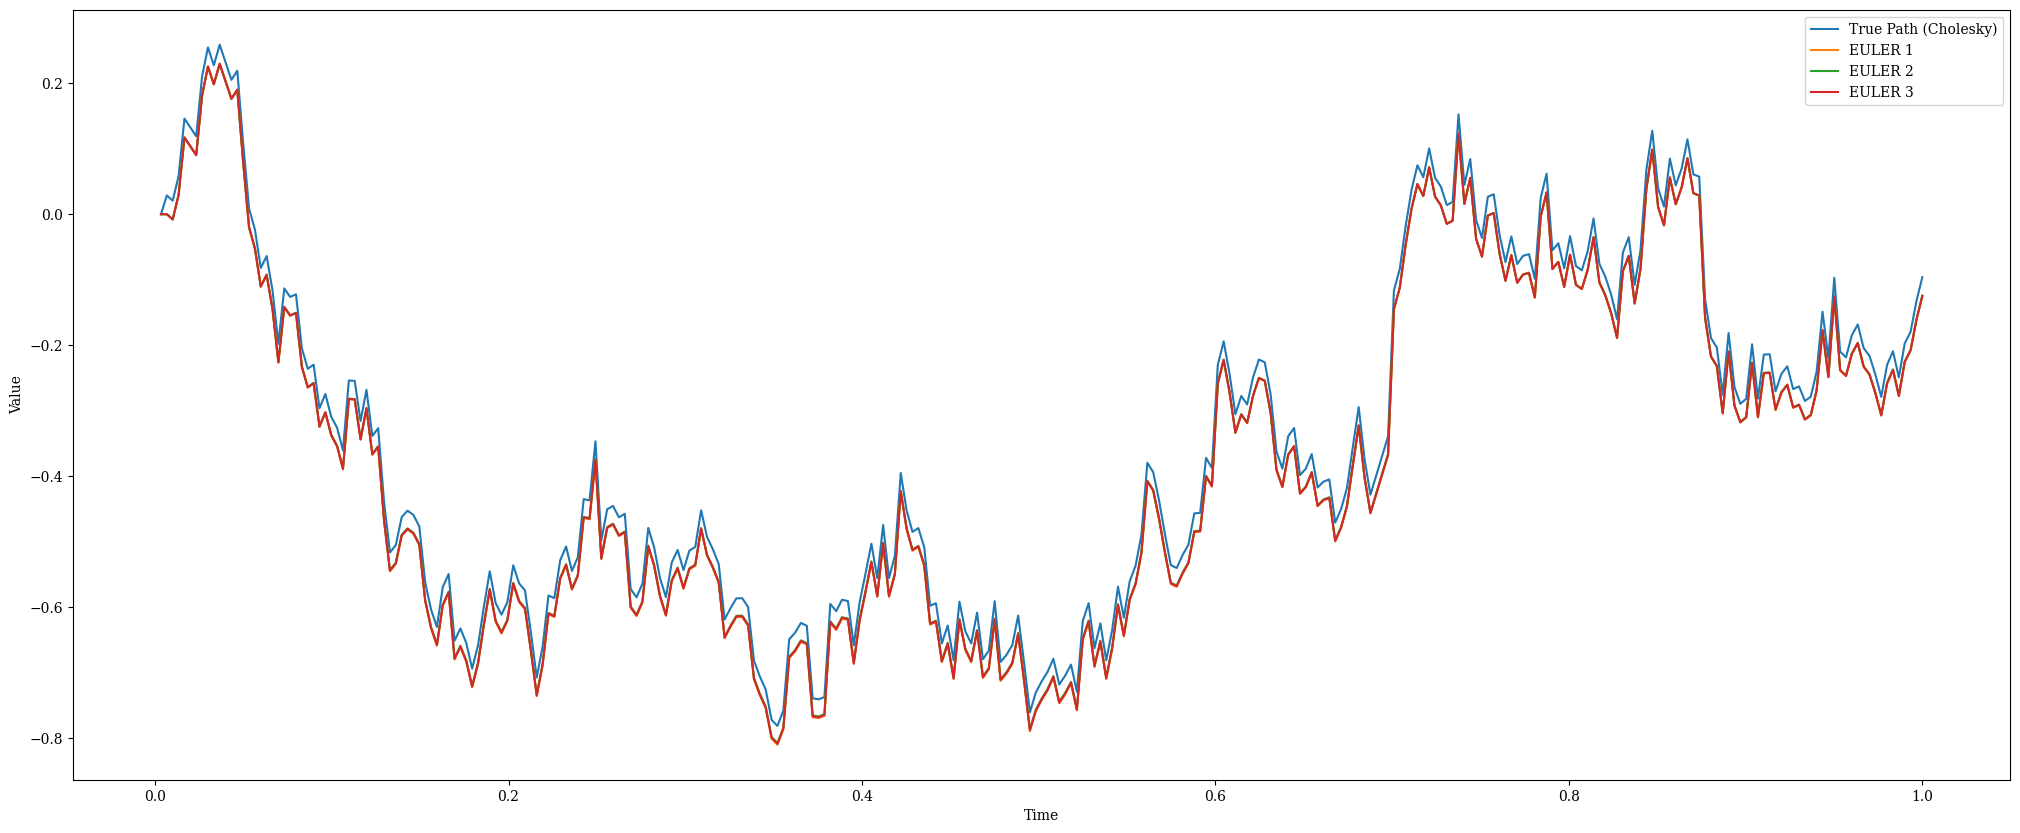

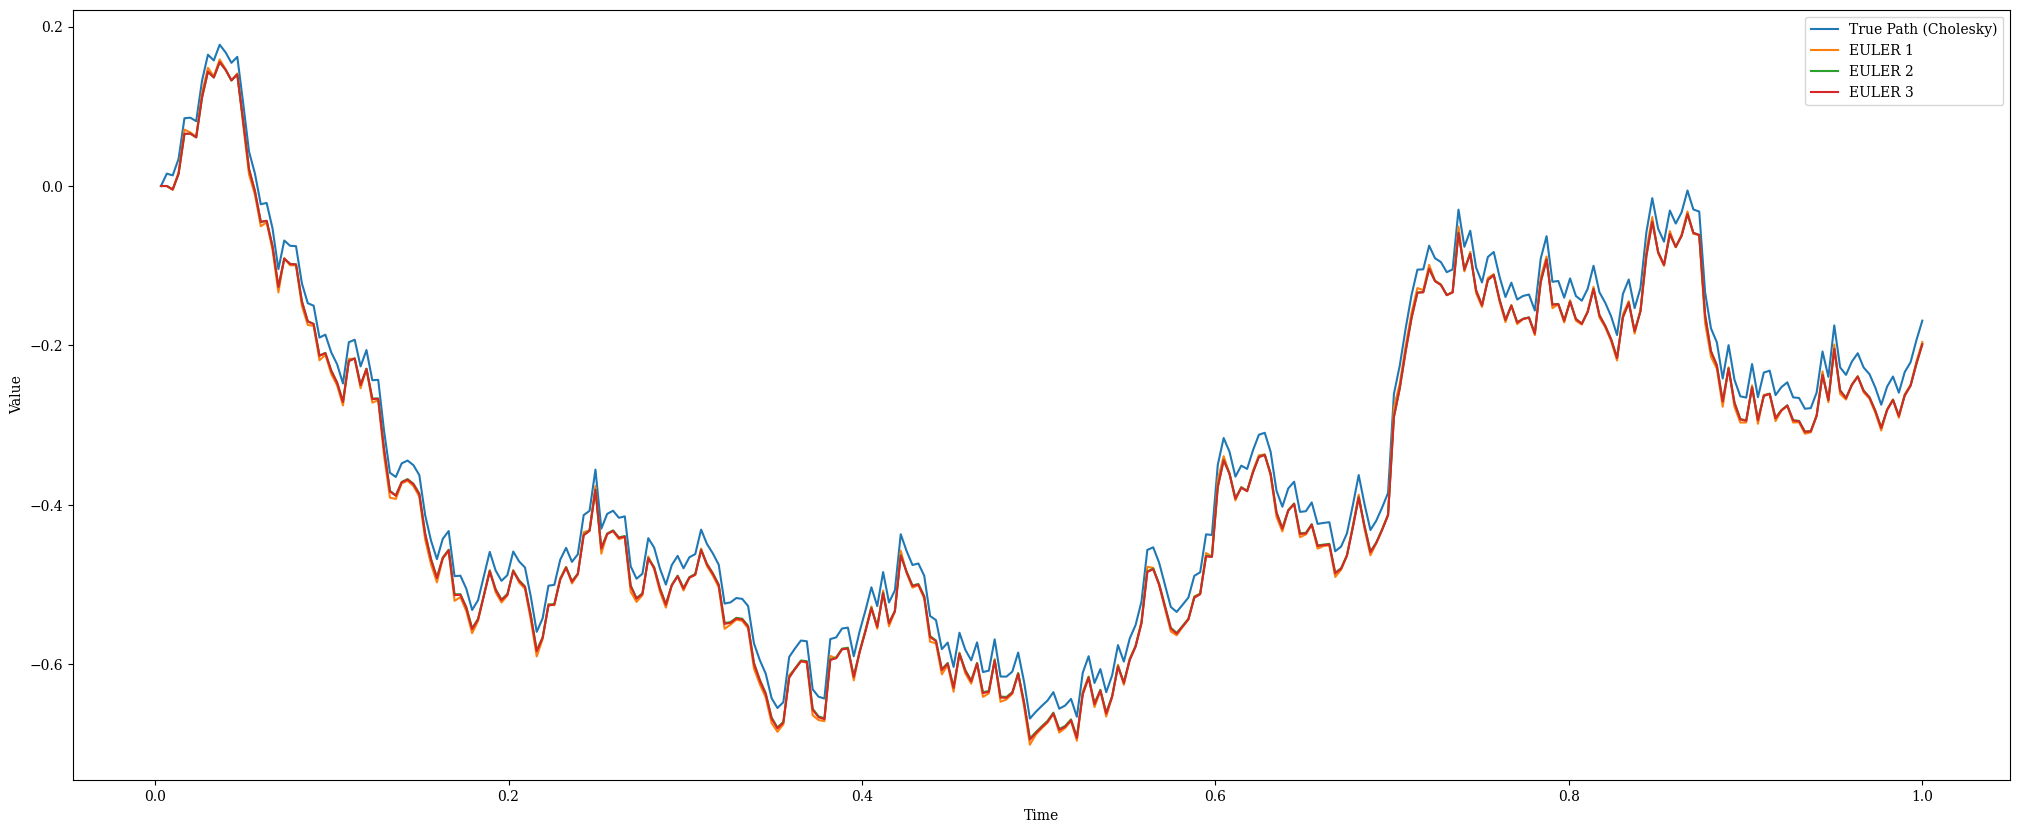

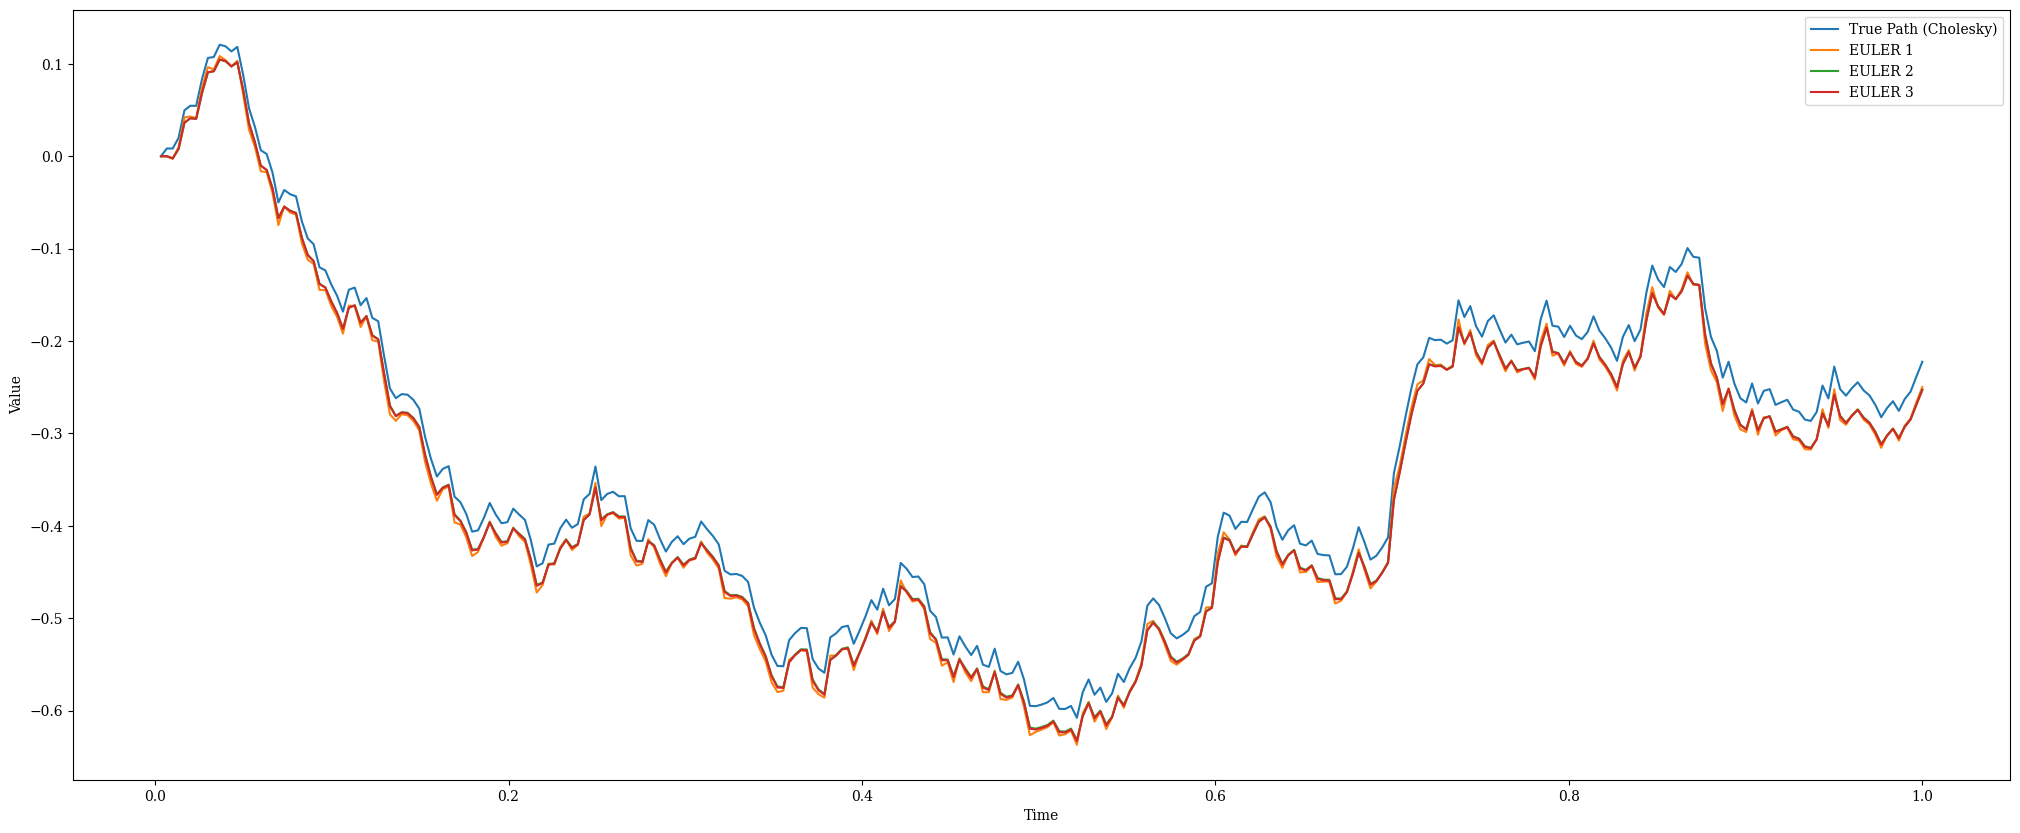

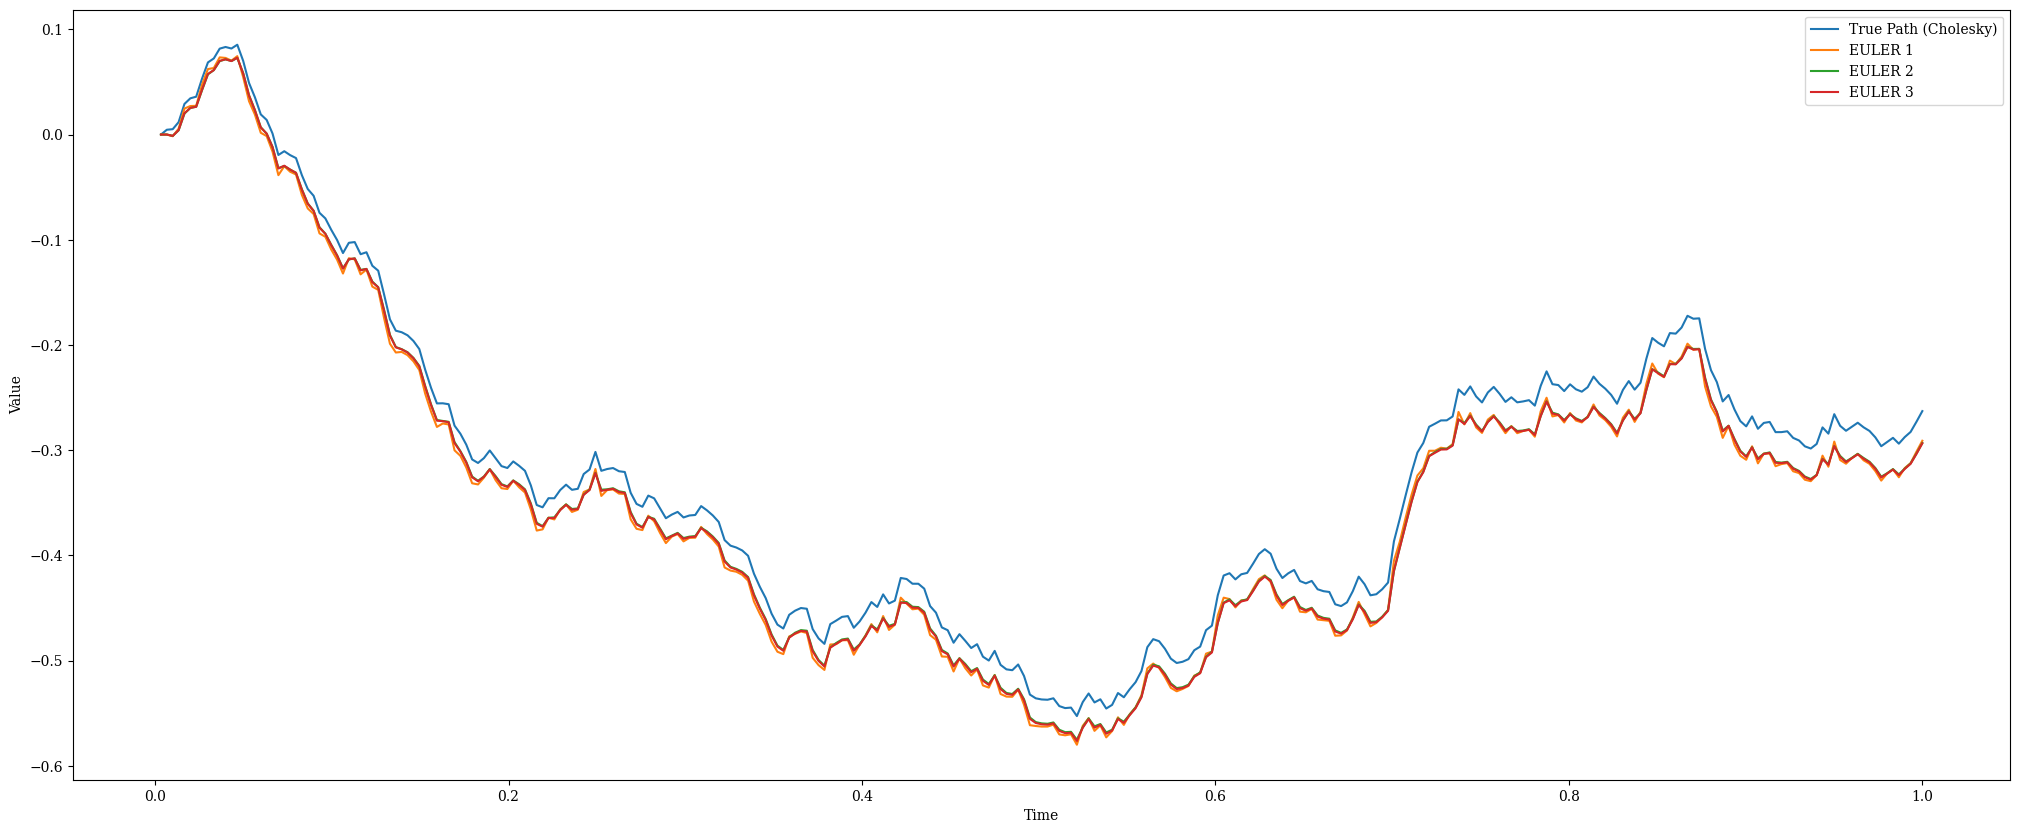

In [ ]:
def print_results(T, H, nsteps, v):
    np.random.seed(seed=42)
    dt = T/nsteps
    t_values = np.linspace(dt, T, nsteps+1)
    X_euler_1 = np.zeros(nsteps)
    X_euler_2 = np.zeros(nsteps)
    X_euler_3 = np.zeros(nsteps)

    Z = np.random.normal(0, 1, nsteps)
    alpha = H + 0.5

    L = cholesky(v, H, T, nsteps)
    X_cholesky = simu_cholesky(L,Z,T,nsteps)[0]


    for i in range(1, nsteps):
        X_euler_1[i] = X_euler_1[i] + v * np.sqrt(dt) * sum(K(t_values[i],t_values[j-1],H) * Z[j] for j in range(1,i+1))
        X_euler_2[i] = X_euler_2[i] + v * sum((1/(np.sqrt(dt)*alpha*gamma(alpha)) * ((t_values[i]-t_values[j-1])**(alpha) - (t_values[i]-t_values[j])**(alpha)) * Z[j] for j in range(1,i+1)))
        X_euler_3[i] = X_euler_3[i] + v * sum((1/gamma(alpha)) * np.sqrt(((t_values[i]-t_values[j-1])**(2*H) - (t_values[i]-t_values[j])**(2*H))/(2*H)) * Z[j] for j in range(1,i+1))

    X_euler_1 = np.concatenate(([0], X_euler_1))
    X_euler_2 = np.concatenate(([0], X_euler_2))
    X_euler_3 = np.concatenate(([0], X_euler_3))


    # Compute MSE
    # mse_euler1 = np.sqrt(np.mean((X_cholesky - X_euler_1)**2))
    # mse_euler2 = np.sqrt(np.mean((X_cholesky - X_euler_2)**2))
    # mse_euler3 = np.sqrt(np.mean((X_cholesky - X_euler_3)**2))

    # Plotting
    plt.plot(t_values, X_cholesky, label='True Path (Cholesky)')
    plt.plot(t_values, X_euler_1, label='EULER 1')
    plt.plot(t_values, X_euler_2, label='EULER 2')
    plt.plot(t_values, X_euler_3, label='EULER 3')
    # plt.title(f'Euler Schemes Comparison for H={H}, MSE: EULER 1={mse_euler1:.4f}, EULER 2={mse_euler2:.4f}, EULER 3={mse_euler3:.4f}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return None

for H in [0.001 ,0.01, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8]:
  print_results(T, H, nsteps, v)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">3. Multifactor approximations</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> Embrace the challenge, and push the boundaries of what's possible by making non-standard multifactor approximations work effectively. </strong></p>



Based on
- Abi Jaber, E., & El Euch, O. (2019). Multifactor approximation of rough volatility models. SIAM Journal on Financial Mathematics, 10(2), 309-349. https://arxiv.org/abs/1801.10359
- Abi Jaber, E. (2019). Lifting the Heston model. Quantitative Finance, 19(12), 1995-2013. https://arxiv.org/abs/1810.04868

$ X_t \approx X_0 + \nu \sum_{k=1}^n  c_k^n Y^{k}_t$
 with  $ Y^k_t = \int_0^t e^{-x_k(t-s)}dW_s$

$ Y^k_{t_i} = e^{-x_k h} Y^k_t + \xi_i^k , \quad \xi_i^k = \int_{t_{i-1}}^{t_i}e^{-x_k(t_i-s)}dW_s$
with the parametrization:

    
$c^n_i = \frac{(r_n^{(1-\alpha)}-1) r_n^{(\alpha-1)(1+n/2)}}{\Gamma(\alpha)\Gamma(1-\alpha)(1-\alpha)}r_n^{(1-\alpha)i$},  \quad  x^n_i = \frac {1-\alpha}{2-\alpha} \frac{r_n^{2-\alpha}-1}{r_n^{1-\alpha}-1} r_n^{i-1-n/2} $,

where $ \alpha:=H+1/ 2$, with a geometric repartition $\eta^n_i=r_n^i$ for some $r_n$ such that
		$ r_n \downarrow 1 \quad \mbox{and} \quad n \ln r_n \to \infty, \quad \mbox{as } n \to \infty.$
</div>
We denote by
$$ K_n(t) = \sum_{i=1}^n c_i^n e^{-x_i^n t}. $$

The first step is to determine a good value or $r_n$ for a choice of $n$, $H$ and $T$.  For this, for a given $H,n,T$,  we can choose $r_n$ to minimize
$$ \int_0^T |K_n(t)-K(t)|^2 dt $$

**Question:** Develop the expression (by developing the square) and show that it admits an explicit expression in terms of incomplete gamma function. Write a minimization function to find r and sanity check with the following table ($H=0.1$, $T=0.5$)

<img src="images/tablr.png" alt="Transposition of a vector" title="Vector transposition" width="400">


**Answer:**....

On va décomposer l'expression suivante $ \int_0^T |K_n(t)-K(t)|^2 dt $ afin de la simplifier :

$$ \int_0^T |K_n(t)-K(t)|^2 dt  = \int_0^T K_n^2(t) - 2K(t)K_n(t) +K^2(t) dt$$


 - $\int_0^T K_n^2(t)dt = \sum_{1 \leq i,j \leq n} c_i c_j \int_0^T e^{-(x_i+x_j)t} dt = \sum_{1 \leq i,j \leq n} \frac{c_i c_j}{x_i+x_j} \int_0^{(x_i+x_j)T} t^{1-1} e^{-t} dt =  \sum_{1 \leq i,j \leq n} \frac{c_i c_j}{x_i+x_j} \gamma(1,(x_i+x_j)T) $

 - $\int_0^T - 2K(t)K_n(t)dt = \frac{-2}{\Gamma(H+1/2)} \sum_{i = 1}^n c_i \int_0^T t^{H-1/2} e^{-x_it} dt =  \frac{-2}{\Gamma(H+1/2)} \sum_{i = 1}^n \frac{c_i}{x_i \times x_i^{H-1/2}} \int_0^{x_iT} t^{H+1/2-1} e^{-t} dt = \
\frac{-2}{\Gamma(H+1/2)}\sum_{i = 1}^n \frac{c_i}{x_i^{H+1/2}} \gamma(H+1/2,x_i T) $

 - $\int_0^T K^2(t)dt = \frac{1}{\Gamma^2(H+1/2)}\int_0^T t^{2H-1} = \frac{T^{2H}}{2H × \Gamma^2(H+1/2)}$

Donc :

$$ \int_0^T |K_n(t)-K(t)|^2 dt = \sum_{1 \leq i,j \leq n} \frac{c_i c_j}{x_i+x_j} \gamma(1,(x_i+x_j)T) - \
\frac{2}{\Gamma(H+1/2)}\sum_{i = 1}^n \frac{c_i}{x_i^{H+1/2}} \gamma(H+1/2,x_i T) +  \frac{T^{2H}}{2H × \Gamma^2(H+1/2)}$$


La définition de la fonction gamma incomplète est disponible dans le lien suivant : https://en.wikipedia.org/wiki/Incomplete_gamma_function.

In [ ]:
T_prime = 0.5

# Fonction gamma incomplète non-normalisée
def incomplete_gamma(a, x):
    return gammainc(a, x) * gamma(a)

def c_n(alpha, k, r):
    coeff = (r**(1-alpha) - 1) * (r**((alpha-1) * (1 + k/2))) / (gamma(alpha) * gamma(2 - alpha))
    expo = np.arange(1, k+1) * (1 - alpha)
    return coeff * (r**expo)

def x_n(alpha, k, r):
    coeff = ((1 - alpha) * (r**(2 - alpha) - 1)) / ((r**(1 - alpha) - 1) * (2 - alpha))
    expo = np.arange(1, k+1) - 1 - k/2
    return coeff * (r**expo)

def fonction_objective(r, k, H):
    cn = c_n(H + 0.5, k, r)
    xn = x_n(H + 0.5, k, r)

    # Premier terme
    somme = xn[:, np.newaxis] + xn[:, np.newaxis].T
    m = incomplete_gamma(1, T_prime * somme) / somme
    term1 = cn.T @ m @ cn

    # Deuxième terme
    term2 = (incomplete_gamma(H + 0.5, xn * T_prime) / xn**(H + 0.5)) @ cn
    term2 = 2 / gamma(H + 0.5) * term2

    # Troisième terme
    term3 = T_prime**(2 * H) / (2 * H * gamma(H + 0.5)**0.5)
    return term1 - term2 + term3

H = 0.1
liste_n = [4, 10, 20, 40, 200, 300]
liste_r = []
for k in liste_n:
    result = minimize(lambda r: fonction_objective(r, k, H), x0=10, bounds=[(1.1, 100)], method='Nelder-Mead')
    liste_r.append(np.round(result.x[0],4))

r_db = pd.DataFrame(liste_r, index=liste_n, columns=['r_n'])
r_dict = r_db.to_dict()['r_n']
r_db


r_n
4    50.5458
10   18.0548
20    8.8750
40    4.4737
200   1.6946
300   1.4828

Now that we know how to determin $r$.

# 3.1 Multifactor with Euler methods on factors


We will consider several Euler-type approximations for factors:
1. **Factor-Euler 1** :
$$ \xi_i^k \approx e^{-x_k dt} \sqrt{dt} Z_i $$
2.  **Factor-Euler 2**: writing $dW_s = Z_i ds / \sqrt{dt}$
$$ \xi_i^k \approx \frac{1}{\sqrt{dt}}   \int_{t_{i-1}}^{t_i}e^{-x_k(t_i-s)}ds = \frac{1}{\sqrt{dt}}  \frac{1-e^{-x_k dt}}{x_k}$$
3. **Factor-Euler 3** : using that $\xi^k_i$ is gaussian with variance $\frac{1 - e^{-2x_k h}}{2x_k} $, so that
$$\xi_i^k \approx \sqrt{\frac{1 - e^{-2x_k h}}{2x_k}} Z_i$$
4. **Factor-Euler 4** :: implicit scheme as in lifting heston paper in the appendix
5. **Factor-Euler 5** : modified variance:
$$  X_{t_{i+1}} = X_0 + \nu\sum_{k}  c_k e^{-x_k dt}Y^{k}_{t_i} + \nu \int_{t_i}^{t_{i+1}} K_n({t_{i+1},s}) dW_s$$
approximate second term by variance of original kernel $K$.


## Détail du calcul du factor Euler 4 :

Puisque  $Y^k_{t_i} = e^{-x_k h} Y^k_{t_{i-1}} + \int_{t_{i-1}}^{t_i}e^{-x_k(t_i-s)}dW_s$, $Y^k$ est solution d'une EDS vérifiée par un processus du type OU,
$dY^k_t = -x_k Y^k_t dt + dW_t$.

En développant :
$$Y^k_{t_i} - Y^k_{t_{i-1}} ≈ - x_k Y^k_{t_i}(t_i - t_{i-1}) + (W_{t_{i}} - W_{t_{i-1}})$$

Alors :

$$Y^k_{t_i} ≈ \frac{Y^k_{t_{i-1}}+ (W_{t_{i}} - W_{t_{i-1}})}{1+x_k (t_i - t_{i-1})}  $$


$$Y^k_{t_i} ≈ \sum_{j=1}^{i}\frac{W_{t_{j}} - W_{t_{j-1}}}{(1+x_k (t_i - t_{i-1}))^{i-j+1}}$$

C:\Users\nacer\AppData\Local\Temp\ipykernel_2284\1714438854.py:50: RuntimeWarning: overflow encountered in power
  Y = c_param.T @ (np.tril(1 / (1 + x_param[:, np.newaxis, np.newaxis] * T_param / n_param) ** A) @ (np.sqrt(T_param / n_param) * Z_param))


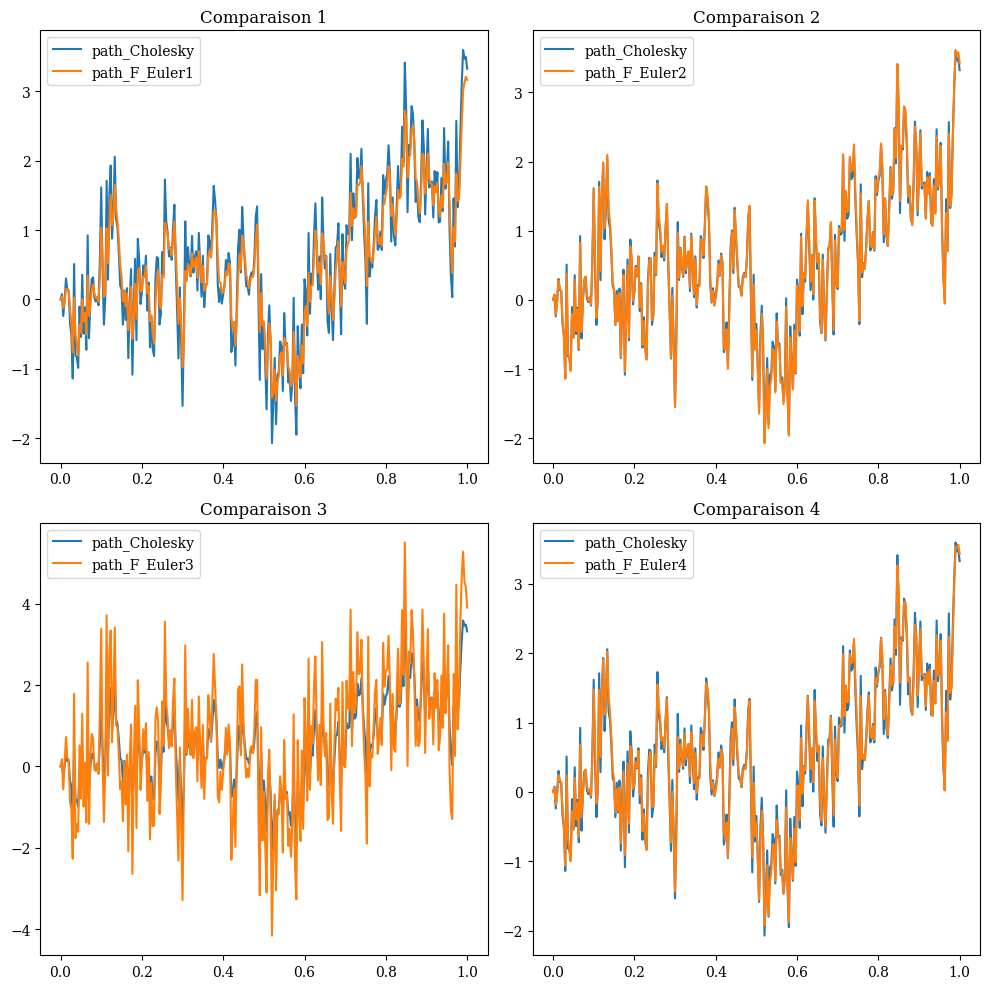

In [ ]:
def calculer_covariance(nu_param, alpha_param, s_param, u_param):
    alpha = alpha_param + 0.5
    s_min, u_max = min(s_param, u_param), max(s_param, u_param)
    k = (nu_param**2) / (scipy.special.gamma(alpha) * scipy.special.gamma(1 + alpha)) * (s_min**alpha / u_max**(1 - alpha)) * scipy.special.hyp2f1(1, 1 - alpha, 1 + alpha, s_min / u_max)
    return k

def calculer_cholesky(nu_param, H_param, T_param, n_steps_param):
    dt = T_param / n_steps_param
    t_vec = np.linspace(dt, T_param, n_steps_param)
    cov_matrix = [[calculer_covariance(nu_param, H_param, t, s) for t in t_vec] for s in t_vec]
    L = np.linalg.cholesky(cov_matrix)
    return L

def simuler_trajet_cholesky(L_param, Z_param, T_param, n_steps_param):
    dt = T_param / n_steps_param
    t_vec = np.linspace(dt, T_param, n_steps_param)
    RL_path = L_param @ Z_param
    return np.concatenate((np.array([0.]), RL_path)), np.concatenate((np.array([0.]), t_vec))



Z = np.random.normal(0, 1, nsteps)
y_cholesky,x=simu_cholesky(L,Z,T,nsteps)


def Euler_multifactor(X_0,nu,c,x,fksi,n,T,Z):
  ksi = fksi(x,T/n,Z)
  a = x.shape
  A = (np.tril(np.ones(n)) @ np.tril(np.ones(n)) -np.tril(np.ones(n)) ) * T/n
  Y = (np.tril(np.exp(-A * x[:,np.newaxis, np.newaxis])) @ ksi.T[:,:,np.newaxis])
  Ys = cn @ Y[:,:,0]
  return X_0 + nu*Ys

k = 40
cn = c_n(H+1/2,k,r_dict[k])
xn = x_n(H+1/2,k, r_dict[k])

def fonction_euler_1(x_param, h_param, Z_param):
    a = Z_param.shape
    return np.sqrt(h_param) * np.exp(-x_param * h_param) * Z_param.reshape((a[0], 1))

def fonction_euler_2(x_param, h_param, Z_param):
    return Z_param[:, np.newaxis] / np.sqrt(h_param) * (1 - np.exp(-x_param * h_param)) / x_param

def fonction_euler_3(x_param, h_param, Z_param):
    return Z_param[:, np.newaxis] * np.sqrt((1 - np.exp(-2 * x_param * h_param)) / (2 * x_param))

def fonction_euler_4(X_0_param, nu_param, c_param, x_param, n_param, T_param, Z_param):
    A = (np.tril(np.ones(n_param)) @ np.tril(np.ones(n_param)))
    Y = c_param.T @ (np.tril(1 / (1 + x_param[:, np.newaxis, np.newaxis] * T_param / n_param) ** A) @ (np.sqrt(T_param / n_param) * Z_param))
    return X_0_param + nu_param * Y

y_FE1 = np.concatenate((np.array([0.]), Euler_multifactor(0, v, cn, xn, fonction_euler_1, nsteps, T, Z)))
y_FE2 = np.concatenate((np.array([0.]), Euler_multifactor(0, v, cn, xn, fonction_euler_2, nsteps, T, Z)))
y_FE3 = np.concatenate((np.array([0.]), Euler_multifactor(0, v, cn, xn, fonction_euler_3, nsteps, T, Z)))
y_FE4 = np.concatenate((np.array([0.]), fonction_euler_4(0, v, cn, xn, nsteps, T, Z)))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#  plot 1
axs[0, 0].plot(x, y_cholesky, label="path_Cholesky")
axs[0, 0].plot(x, y_FE1, label="path_F_Euler1")
axs[0, 0].legend()
axs[0, 0].set_title('Comparaison 1')

#  plot 2
axs[0, 1].plot(x, y_cholesky, label="path_Cholesky")
axs[0, 1].plot(x, y_FE2, label="path_F_Euler2")
axs[0, 1].legend()
axs[0, 1].set_title('Comparaison 2')

#  plot 3
axs[1, 0].plot(x, y_cholesky, label="path_Cholesky")
axs[1, 0].plot(x, y_FE3, label="path_F_Euler3")
axs[1, 0].legend()
axs[1, 0].set_title('Comparaison 3')

# plot 4
axs[1, 1].plot(x, y_cholesky, label="path_Cholesky")
axs[1, 1].plot(x, y_FE4, label="path_F_Euler4")
axs[1, 1].legend()
axs[1, 1].set_title('Comparaison 4')

# Ajuste l'espacement entre les subplots
plt.tight_layout()

# Affiche la figure
plt.show()


## 3.2 Multifactor exact simulation with Cholesky

$$ X_t \approx X_0 + \nu \sum_{k=1}^n  c_k Y^{k}_t$$
with $$  Y^k_t = \int_0^t e^{-x_k(t-s)}dW_s$$
$$  Y^k_{t_i} = e^{-x_k h} Y^k_t + \xi_i^k , \quad \xi_i^k = \int_{t_{i-1}}^{t_i}e^{-x_k(t_i-s)}dW_s$$
We will use exact approximation using Cholseky to simulate $(\xi_i^1, \ldots, \xi_i^n)^\top \sim \mathcal N(0, \Sigma)$ with
$$ \Sigma_{kl} = \int_{t_i}^{t_{i+1}} e^{-(x_k + x_l) (t_{i+1}-s)} ds = \frac{1-e^{-(x_k+x_l)dt}}{x_k + x_l} $$
For each $t_i$ generate $Z_i = (Z_i^1, \ldots, Z_i^n)^\top$ independant standard Gaussian and set
$$ \xi_i = L Z_i \quad \mbox{with } LL^\top \Sigma.$$
Set
$$ E_{dt} = \exp( - \mbox{diag}(x_1, \ldots, x_n )dt  )  $$
Then, $$X_{t_{i+1}} = X_0 + \nu*c^\top E_{dt} Y_{t_i} +  \nu* c^\top L Z_i =  X_0 + \nu*c^\top E_{dt} Y_{t_i} + \nu*\sqrt{c^\top \Sigma c} U_i $$
with
$$  U_i := \frac{ c^\top L Z_i }{ \sqrt{c^\top \Sigma c} } \sim \mathcal N(0,1)$$

$\textbf{Q:}$ What is the difference and main advantage of such method compared to Cholesky of part 1?

The main difference and advantage compared to the Cholesky method from part 1 lie in the way the stochastic process is simulated.

In the Cholesky method from part 1, the Brownian increments are transformed using the Cholesky decomposition of the covariance matrix. It might be computationally expensive, especially when dealing with large matrices and a large number of simulations.

In the current method, an exact simulation is performed for the increments of the stochastic process using the Cholesky factorization, but instead of directly transforming the Brownian increments, the increments of the process are simulated. This is done by generating independent standard Gaussian random variables, transforming them using the Cholesky factorization, and then combining them to form the increments of the process.

The method provides an exact simulation for the increments of the process, which can be advantageous in situations where an exact representation of the process is required.

The method allows for flexibility in choosing the form of the stochastic process and its increments. This flexibility can be beneficial when dealing with complex models or specific requirements.

The method offers a more direct way to understand and analyze the simulation process. By explicitly simulating the increments, users can gain insights into the behavior of the process and the impact of different parameters.

However, it's essential to note that the choice between these methods depends on the specific requirements of the problem at hand, computational efficiency considerations, and the characteristics of the stochastic process being simulated. Each method has its strengths and weaknesses, and the best choice depends on the context of the simulation.

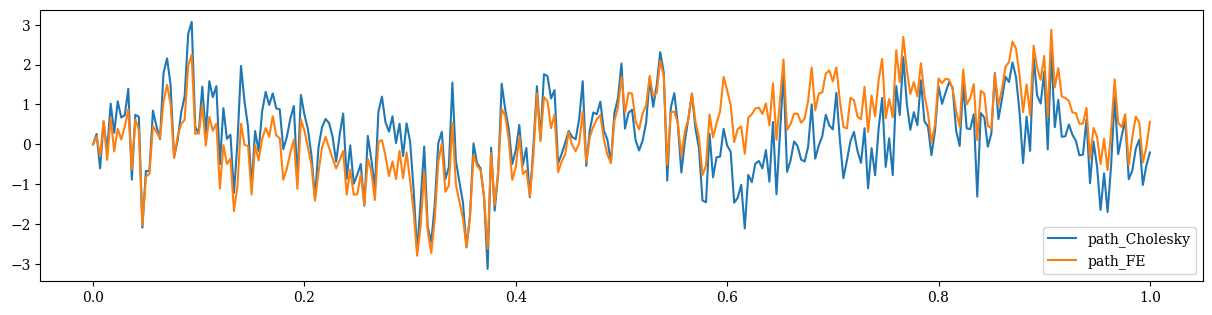

In [ ]:
k = 10
Z2 = np.random.standard_normal((k, nsteps))
cn = c_n(H+1/2,k,r_dict[k])
xn = x_n(H+1/2,k,r_dict[k])


sum_matrix = xn[:,np.newaxis] + xn[:,np.newaxis].T
eps = 10e-12
sigma_ksi = (1-np.exp(-sum_matrix*T/nsteps)) / sum_matrix + eps *np.eye(k)
L2 = np.linalg.cholesky(sigma_ksi)

ksi = L2 @ Z2
U = (cn.T @ L2 @ Z2)/np.sqrt(cn.T @ sigma_ksi @ cn)

def MFChol(X_0,nu,c,x,ksi,n,T):
  a = x.shape
  A = (np.tril(np.ones(n)) @ np.tril(np.ones(n)) - np.tril(np.ones(n))) * T/n
  Y = (np.tril(np.exp(-A * x[:,np.newaxis, np.newaxis])) @ ksi[:,:,np.newaxis])
  Ys = cn @ Y[:,:,0]
  return X_0 + nu*Ys


y_cholesky2, x = simu_cholesky(cholesky(v, H, T, nsteps),U,T,nsteps)
y = np.concatenate((np.array([0.]),MFChol(0,v,cn,xn,ksi,nsteps,T)))
fig = plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
plt.plot(x, y_cholesky2, label="path_Cholesky")
plt.plot(x, y, label="path_FE")
plt.legend()



<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4. Going beyond</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> Simulation is not a one-size-fits-all solution. Break free from the mold and discover new methods to solve the problem at hand. </strong></p>


Explain how the above method can be adapted to the shifted kernel  
$$ K_{\epsilon}(t,s) = \frac{1}{\Gamma(H + 1/2)} (\epsilon + t - s)^{H-1/2} 1_{s<t}$$

Notice that now $H\in (-\infty, \infty)$. Why?

Study the impact of $\epsilon>0$ on the schemes. You can make epsilon vary between  $0$ and $1/52$, also for $\epsilon>0$ you can test with $H$ varying between $-1$ and $0.5$

The shifted kernel introduces a shift parameter, ε, which modifies the original covariance kernel.

To adapt the method to the shifted kernel, we need to modify the covariance matrix calculation and the simulation process.

In the simulation, the Cholesky factorization now involves the covariance matrix for the shifted kernel. The exact simulation of increments using Cholesky factorization remains the same, but the covariance matrix used in the Cholesky factorization is now different.

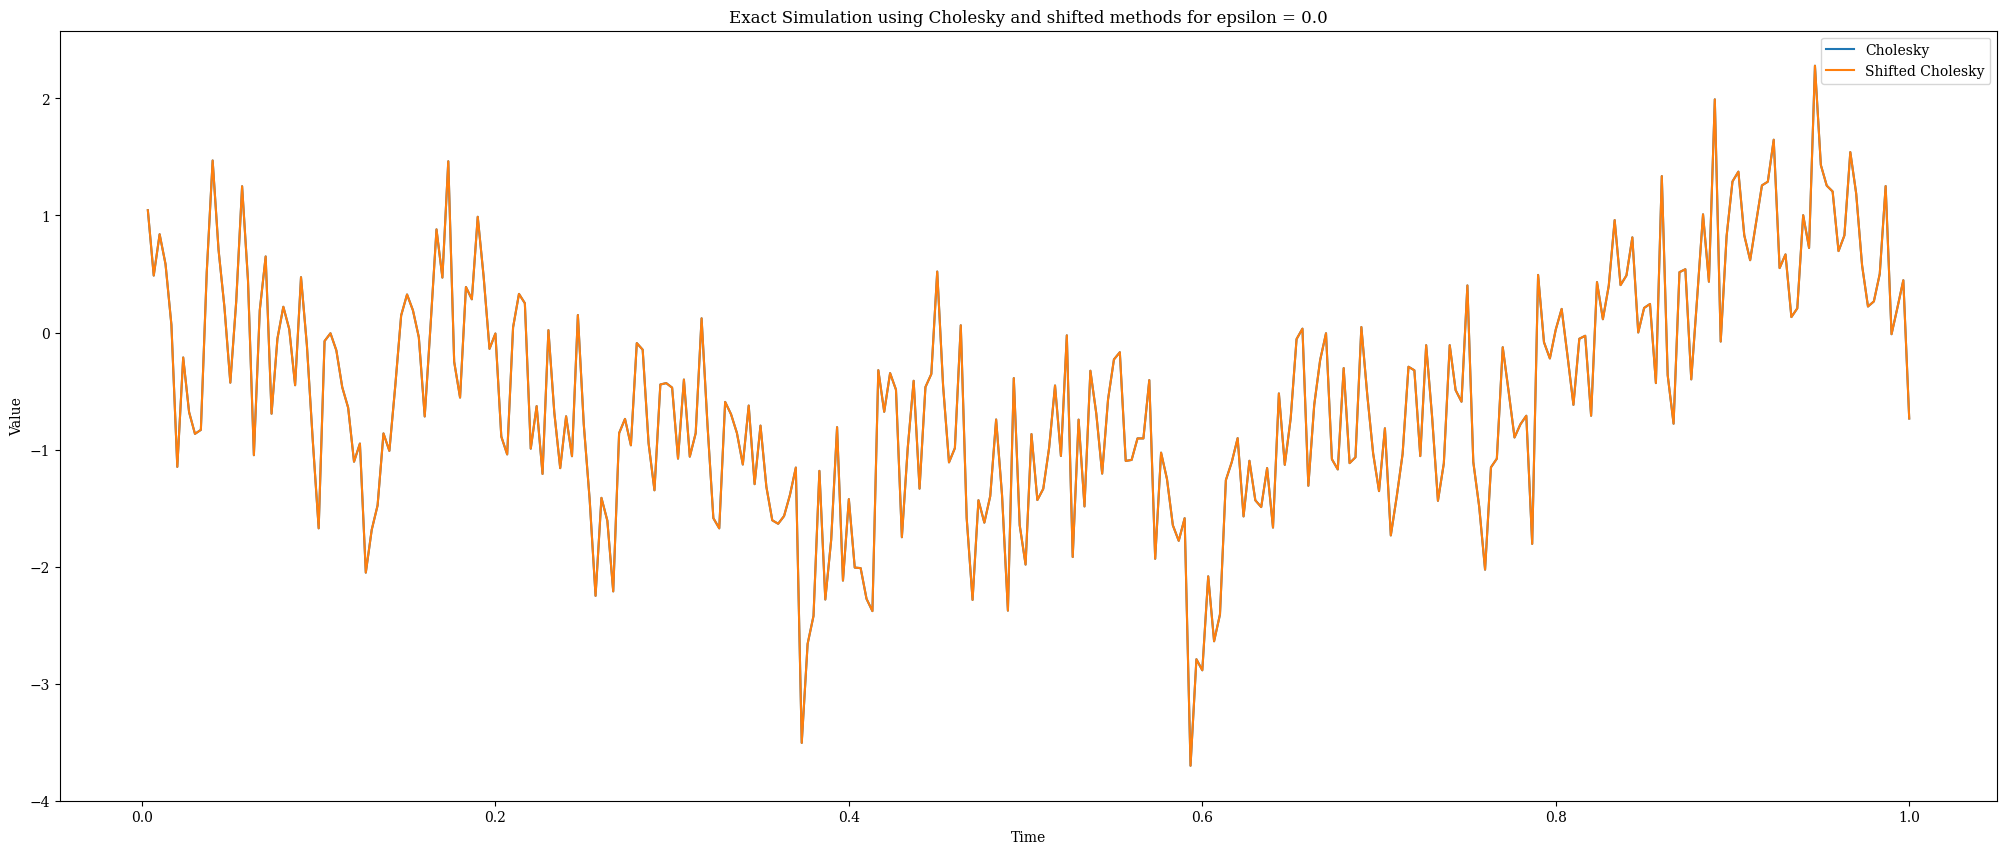

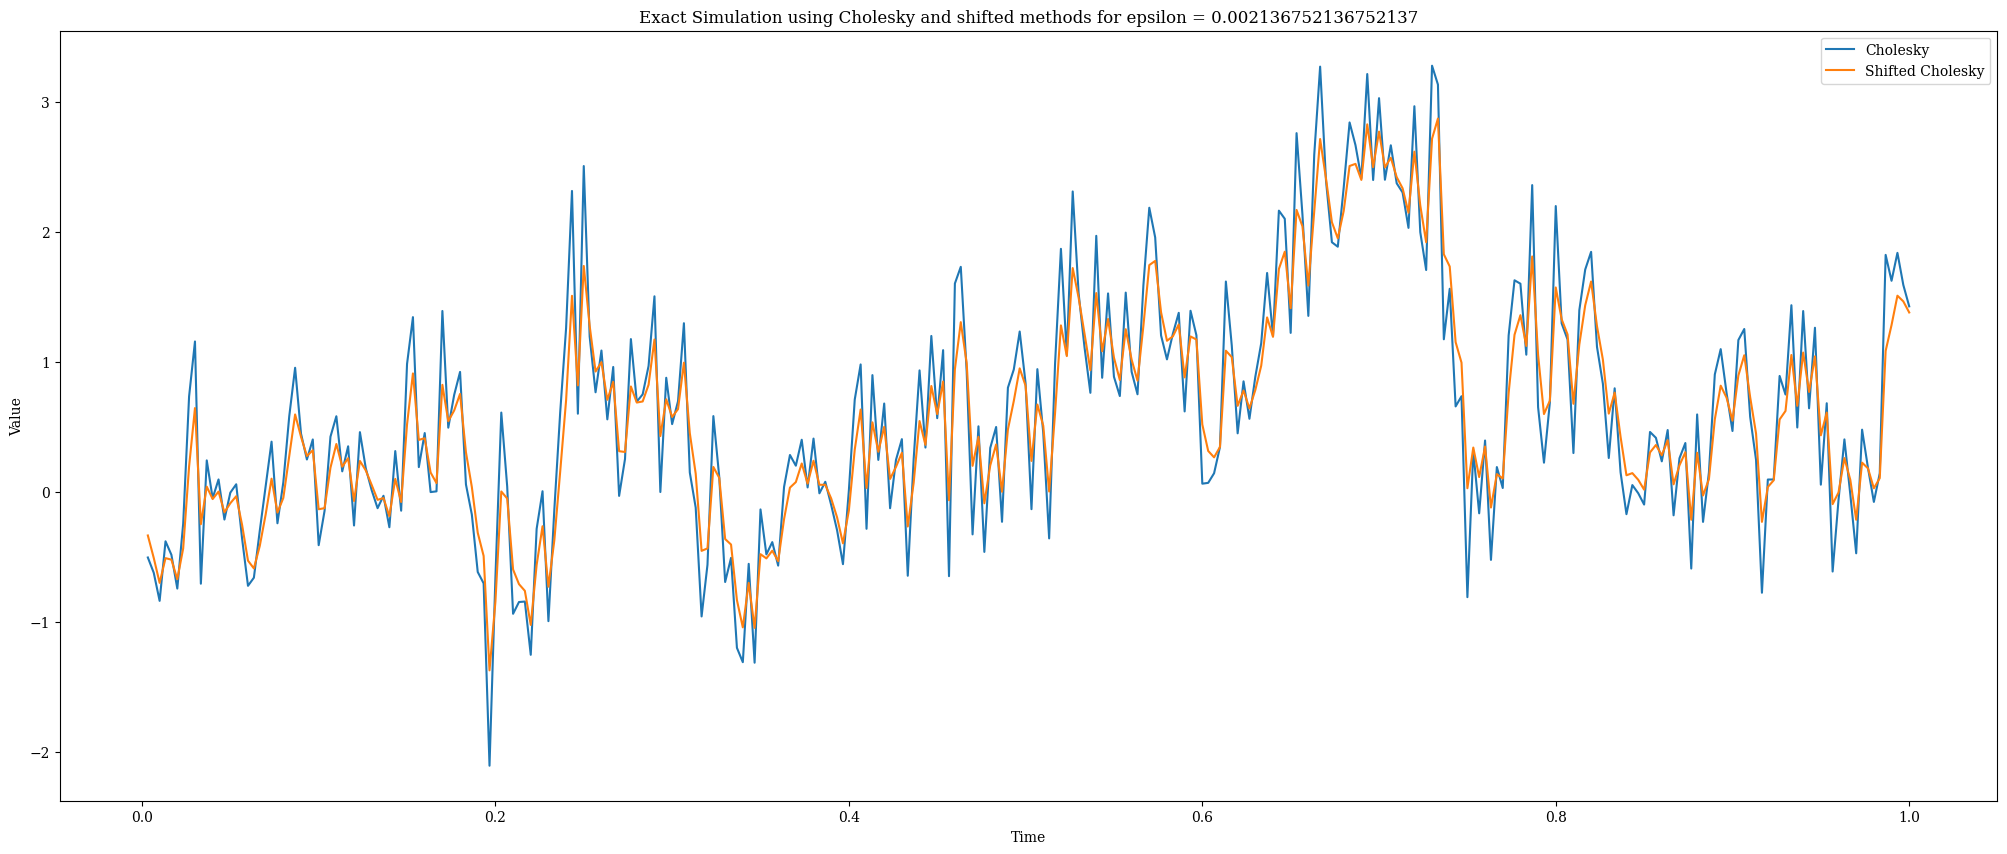

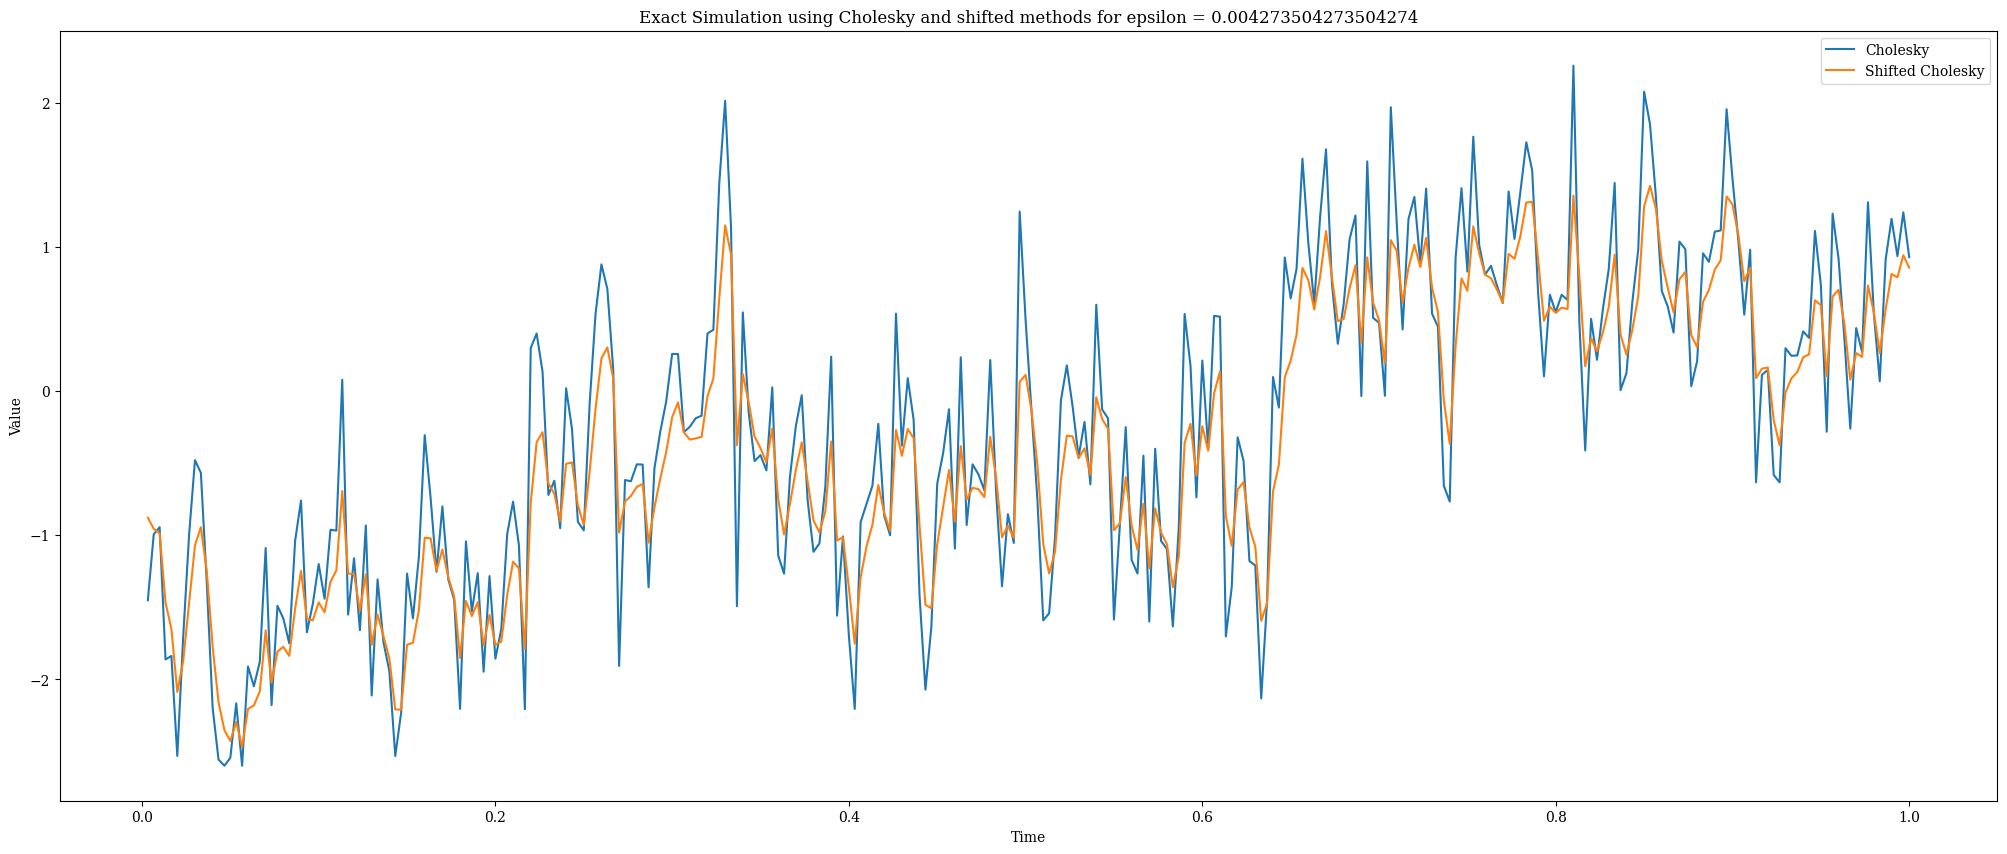

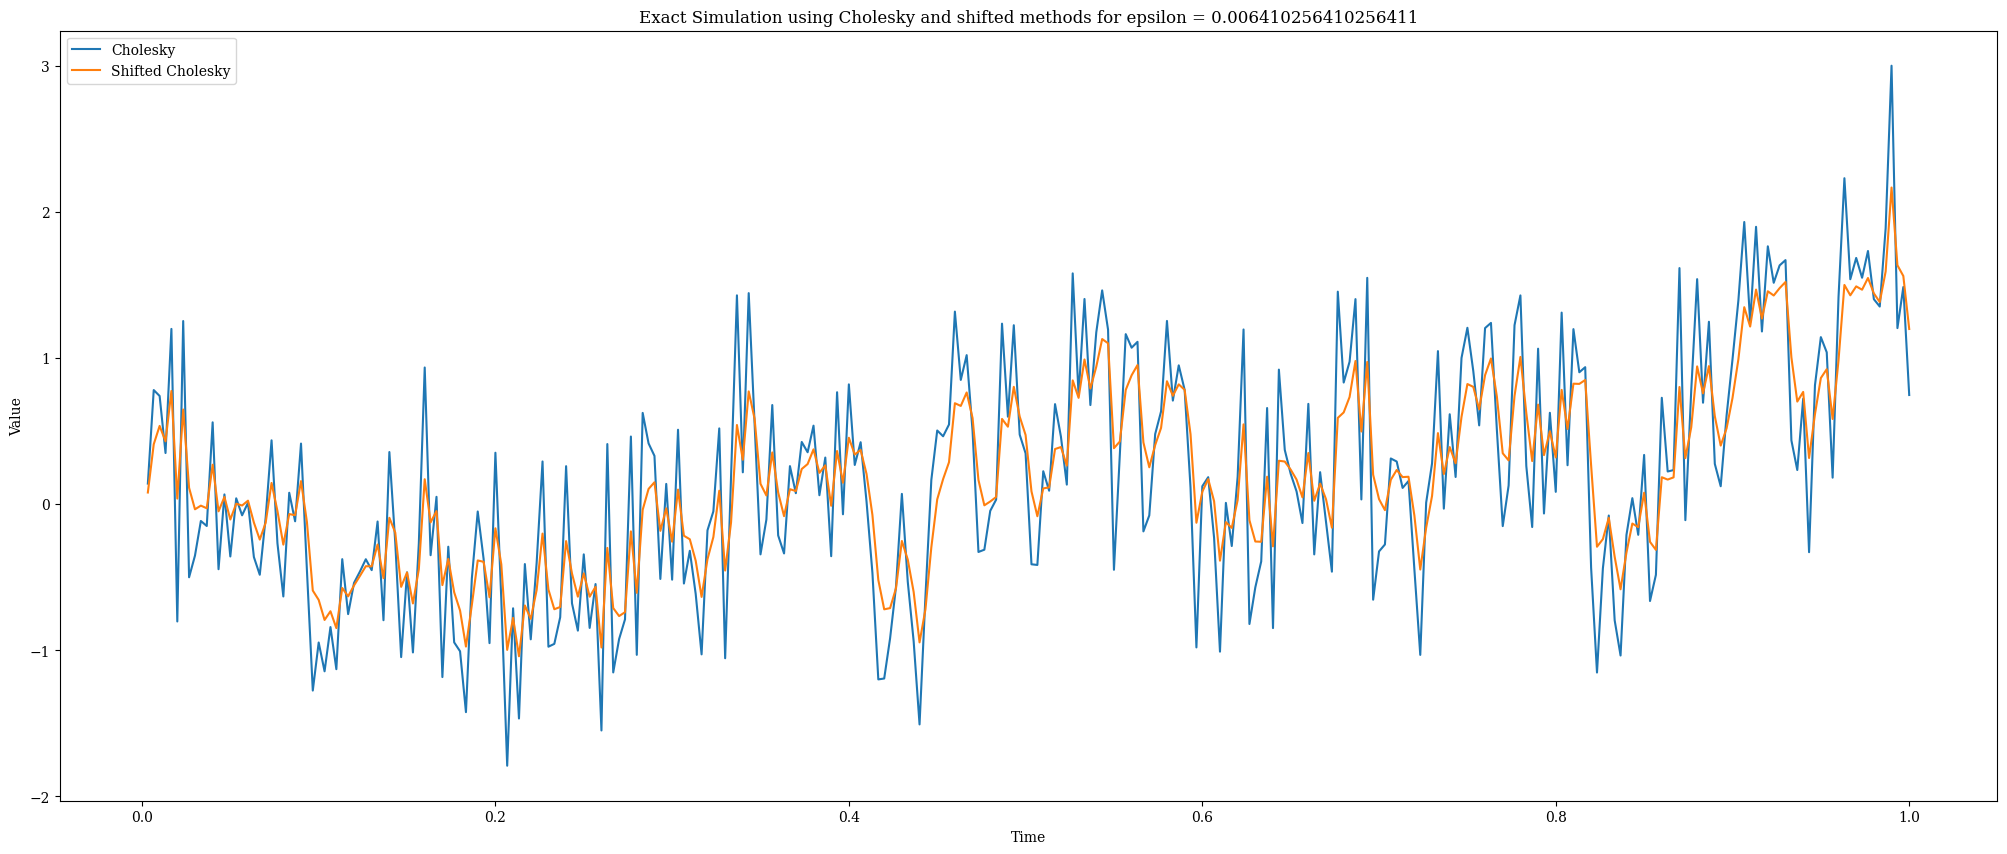

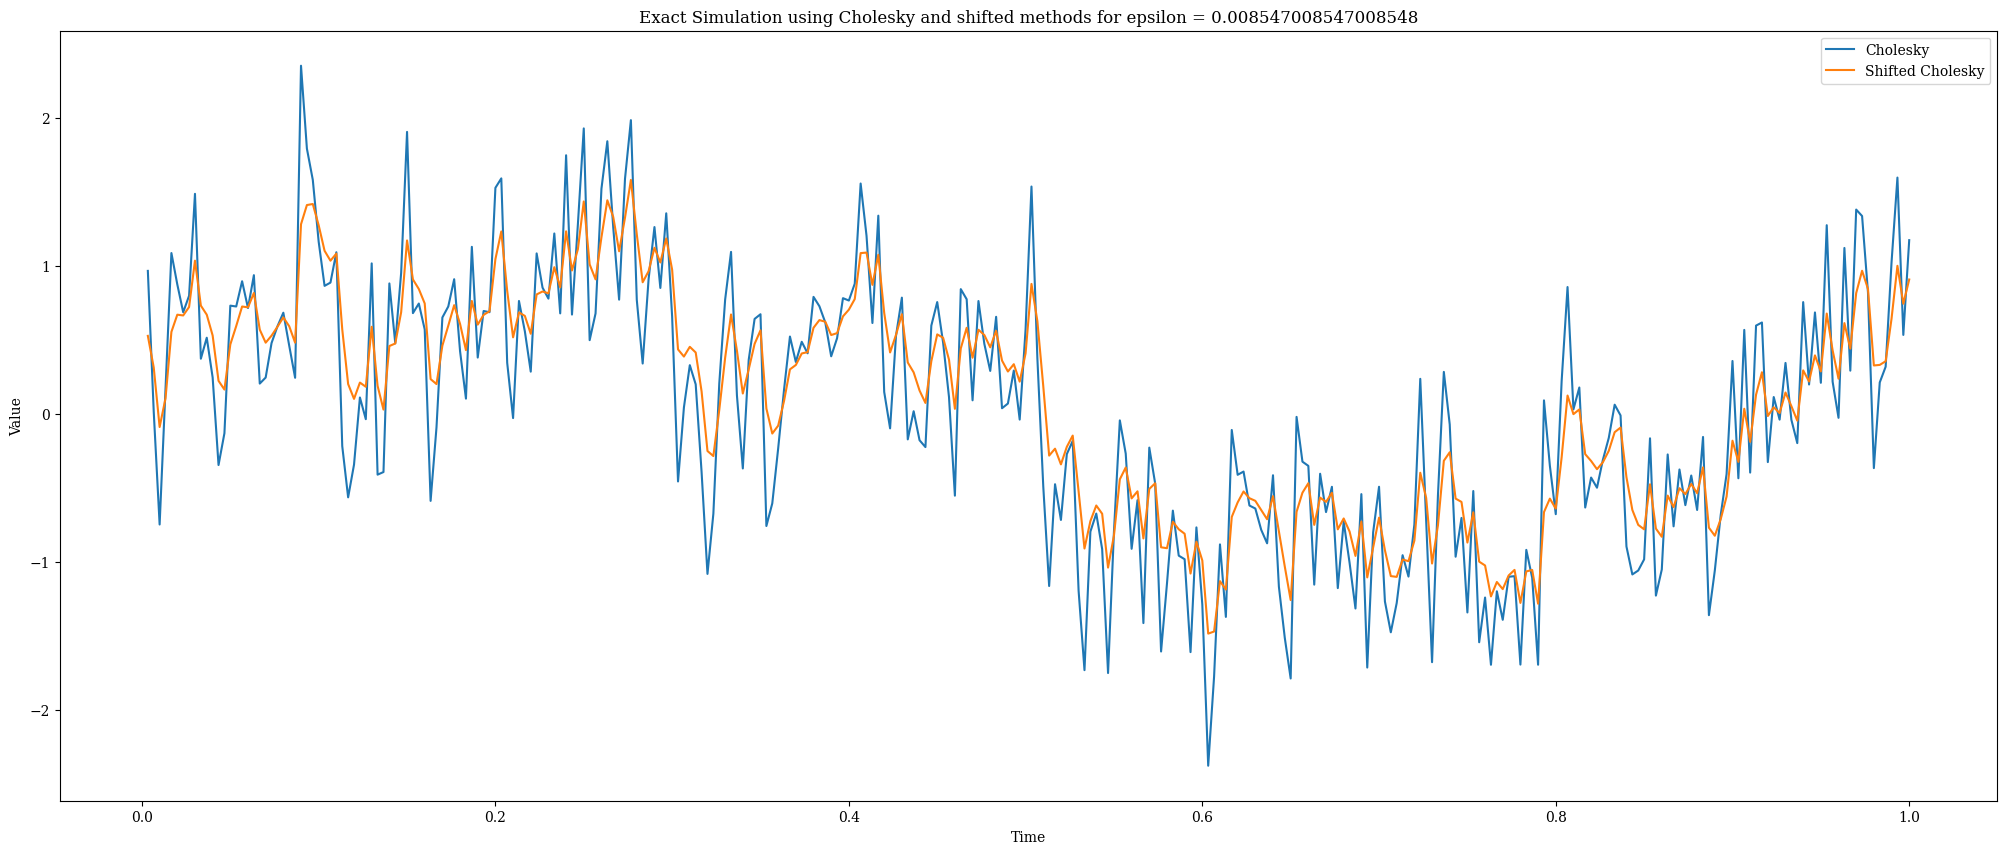

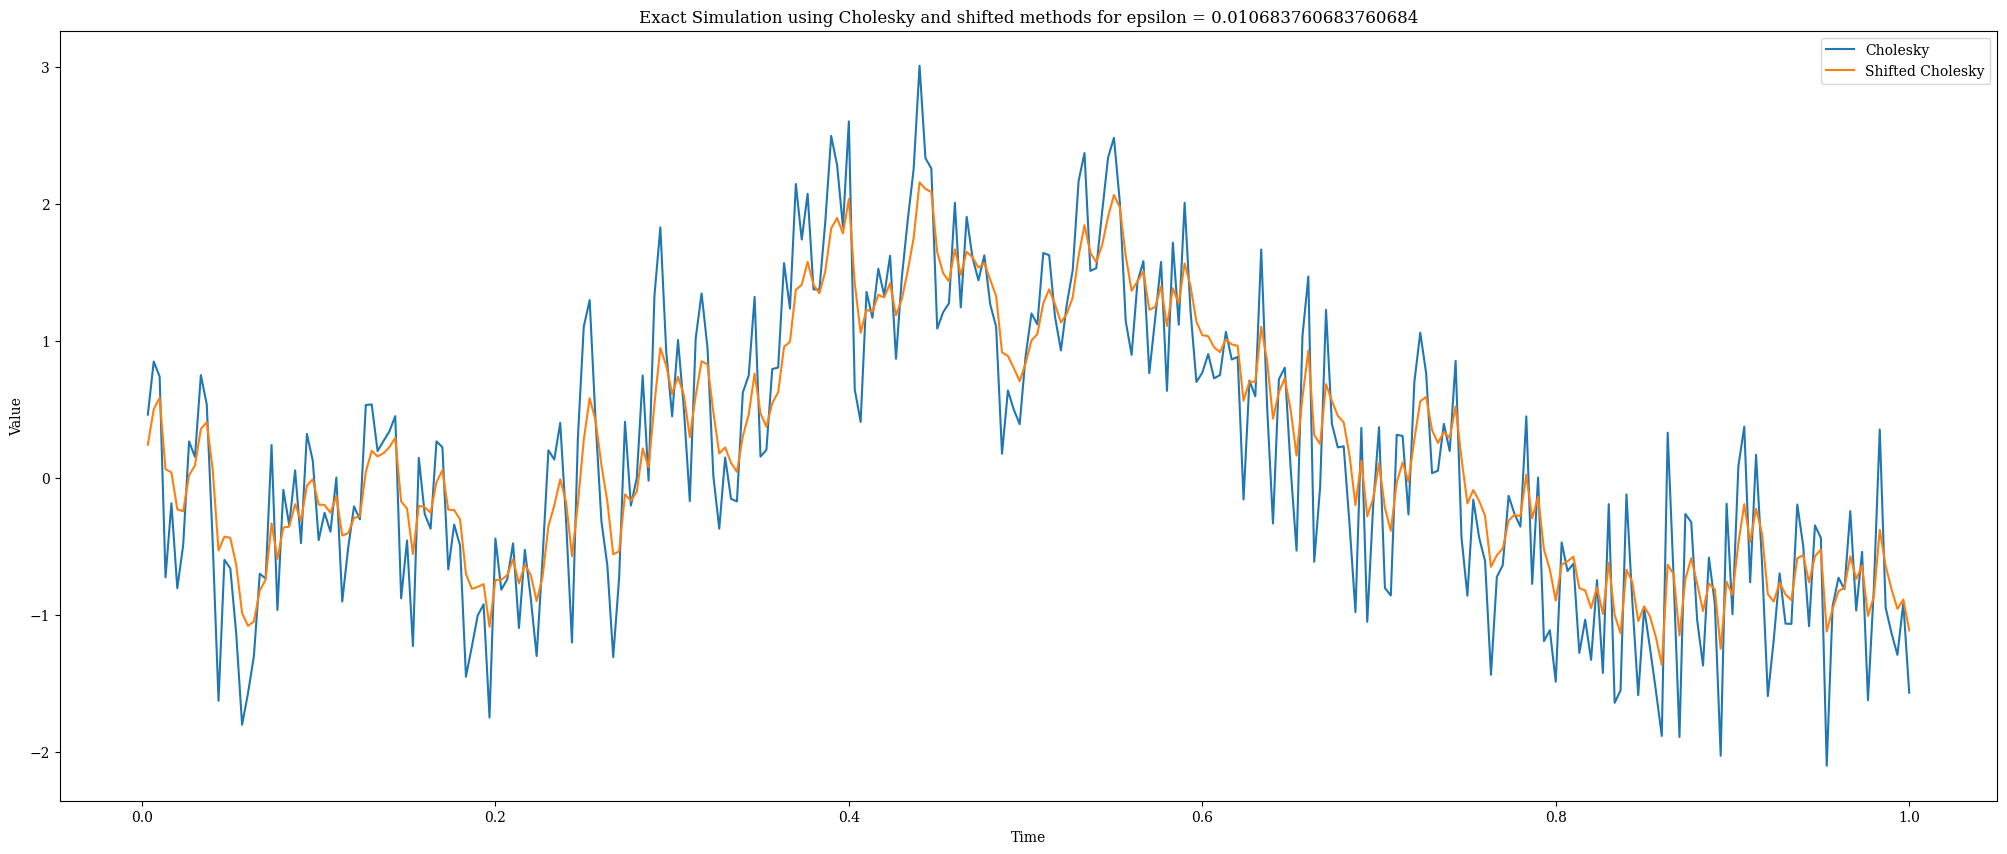

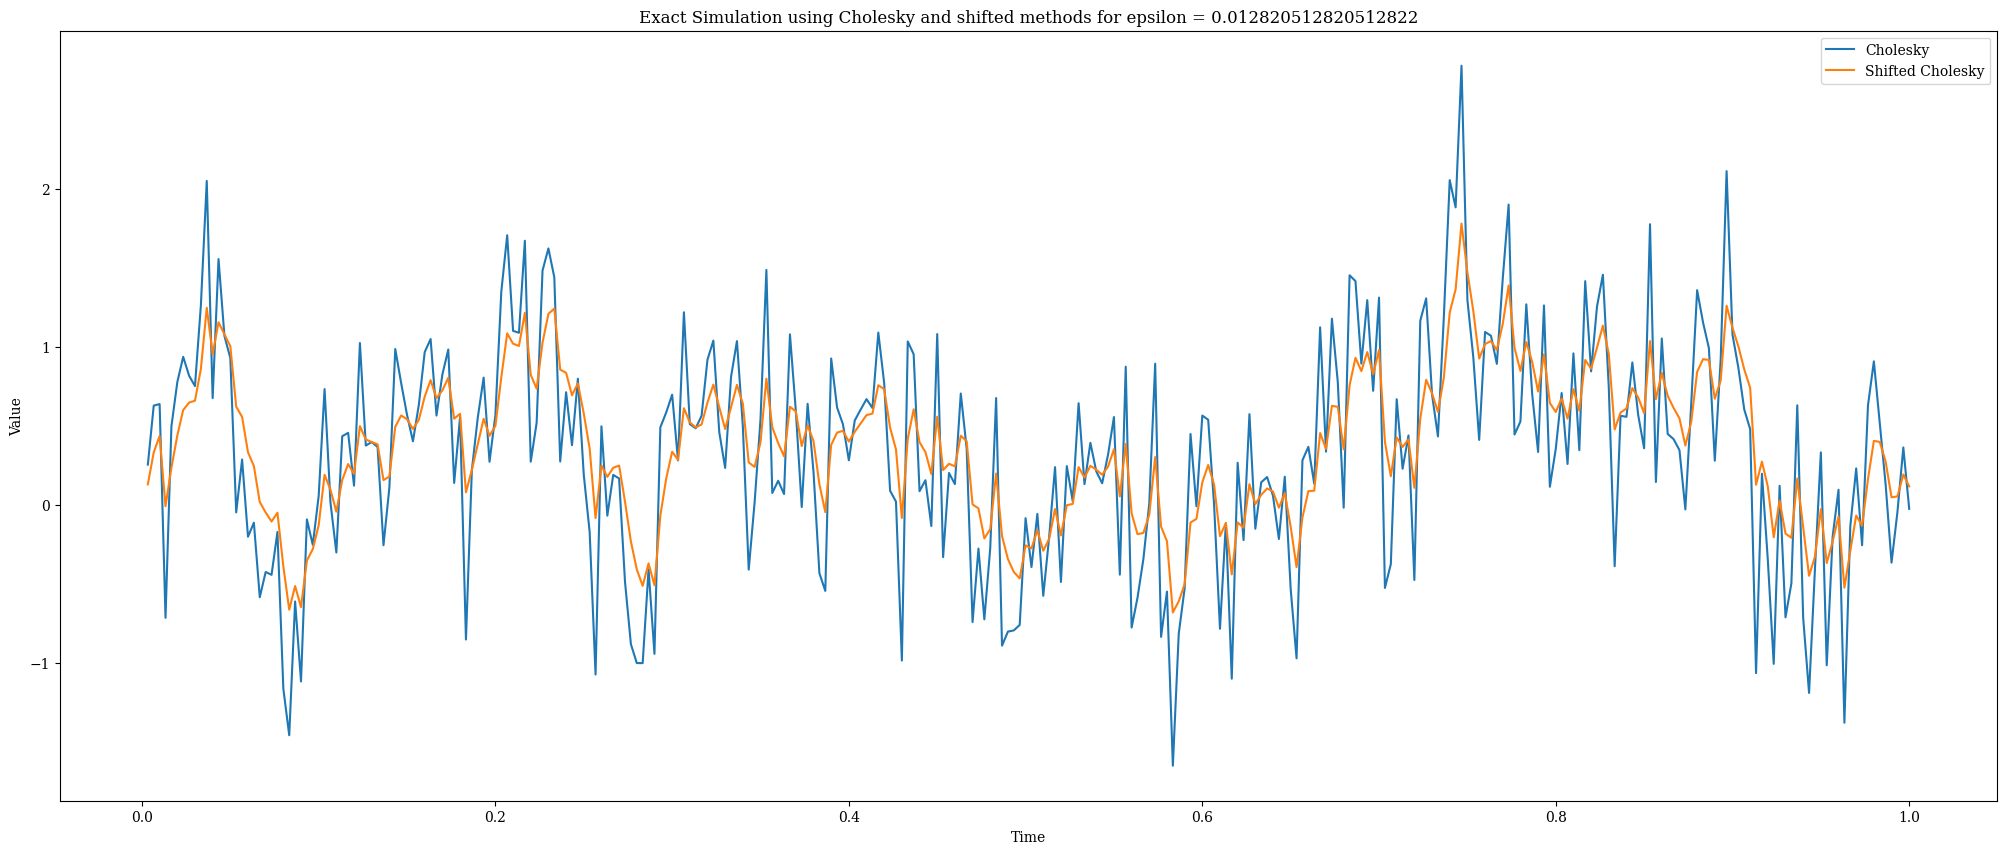

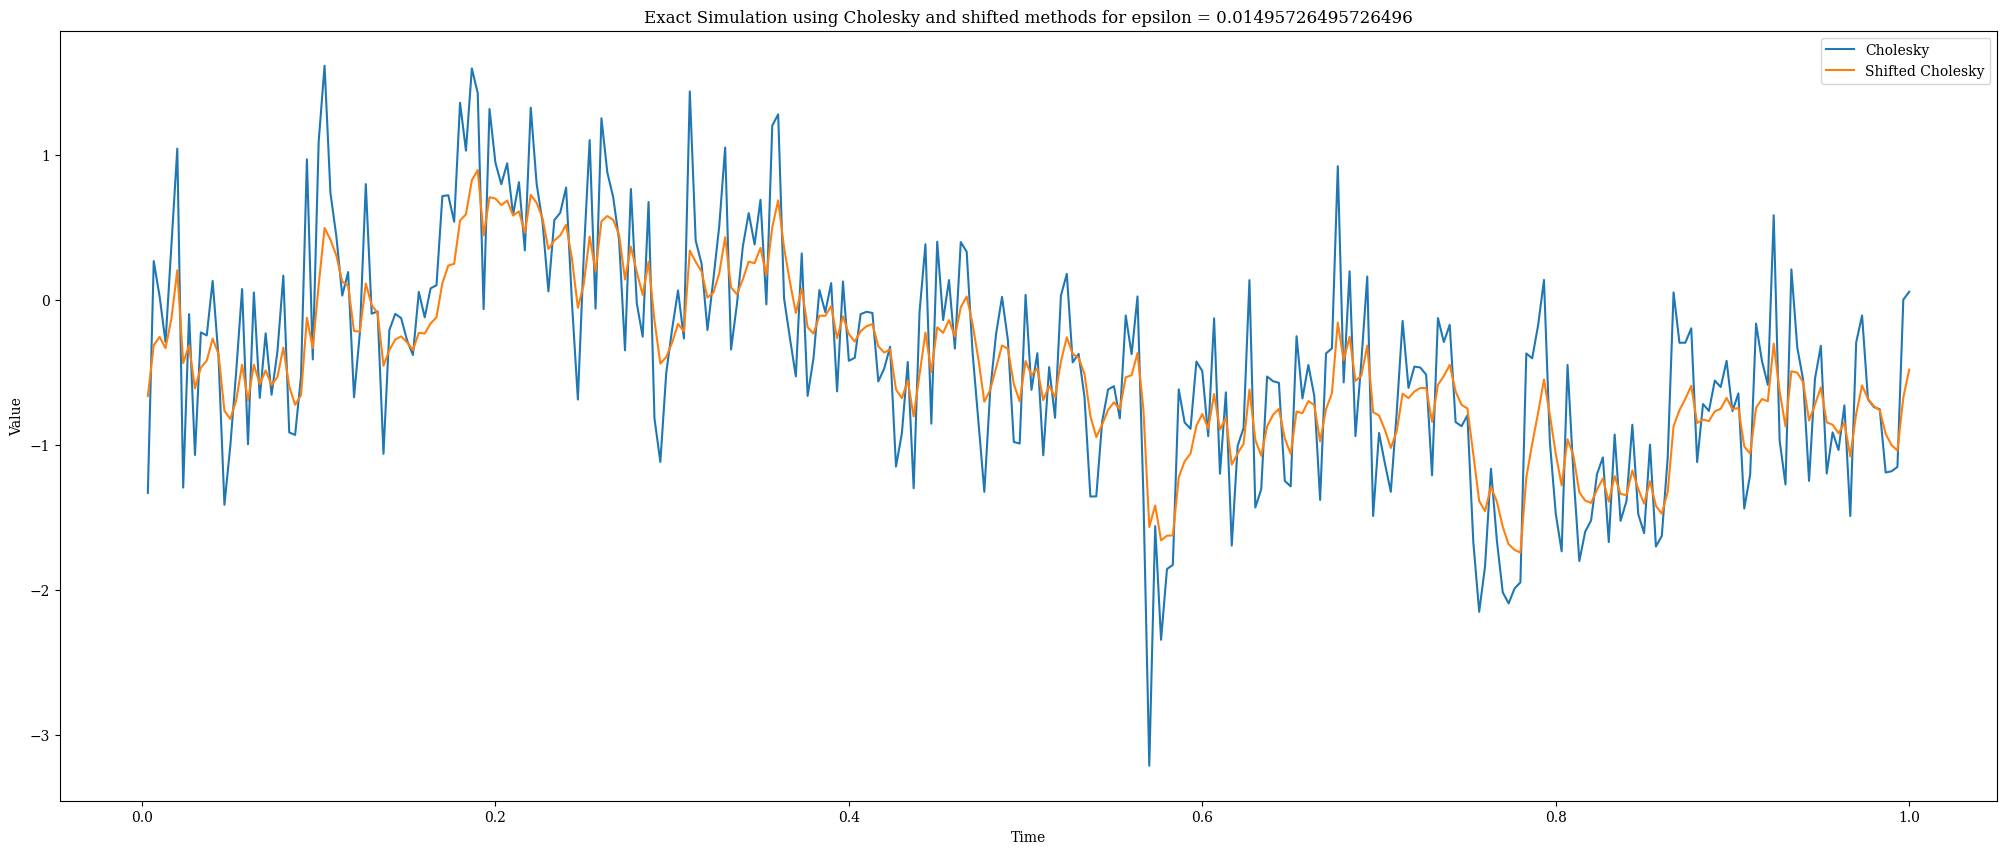

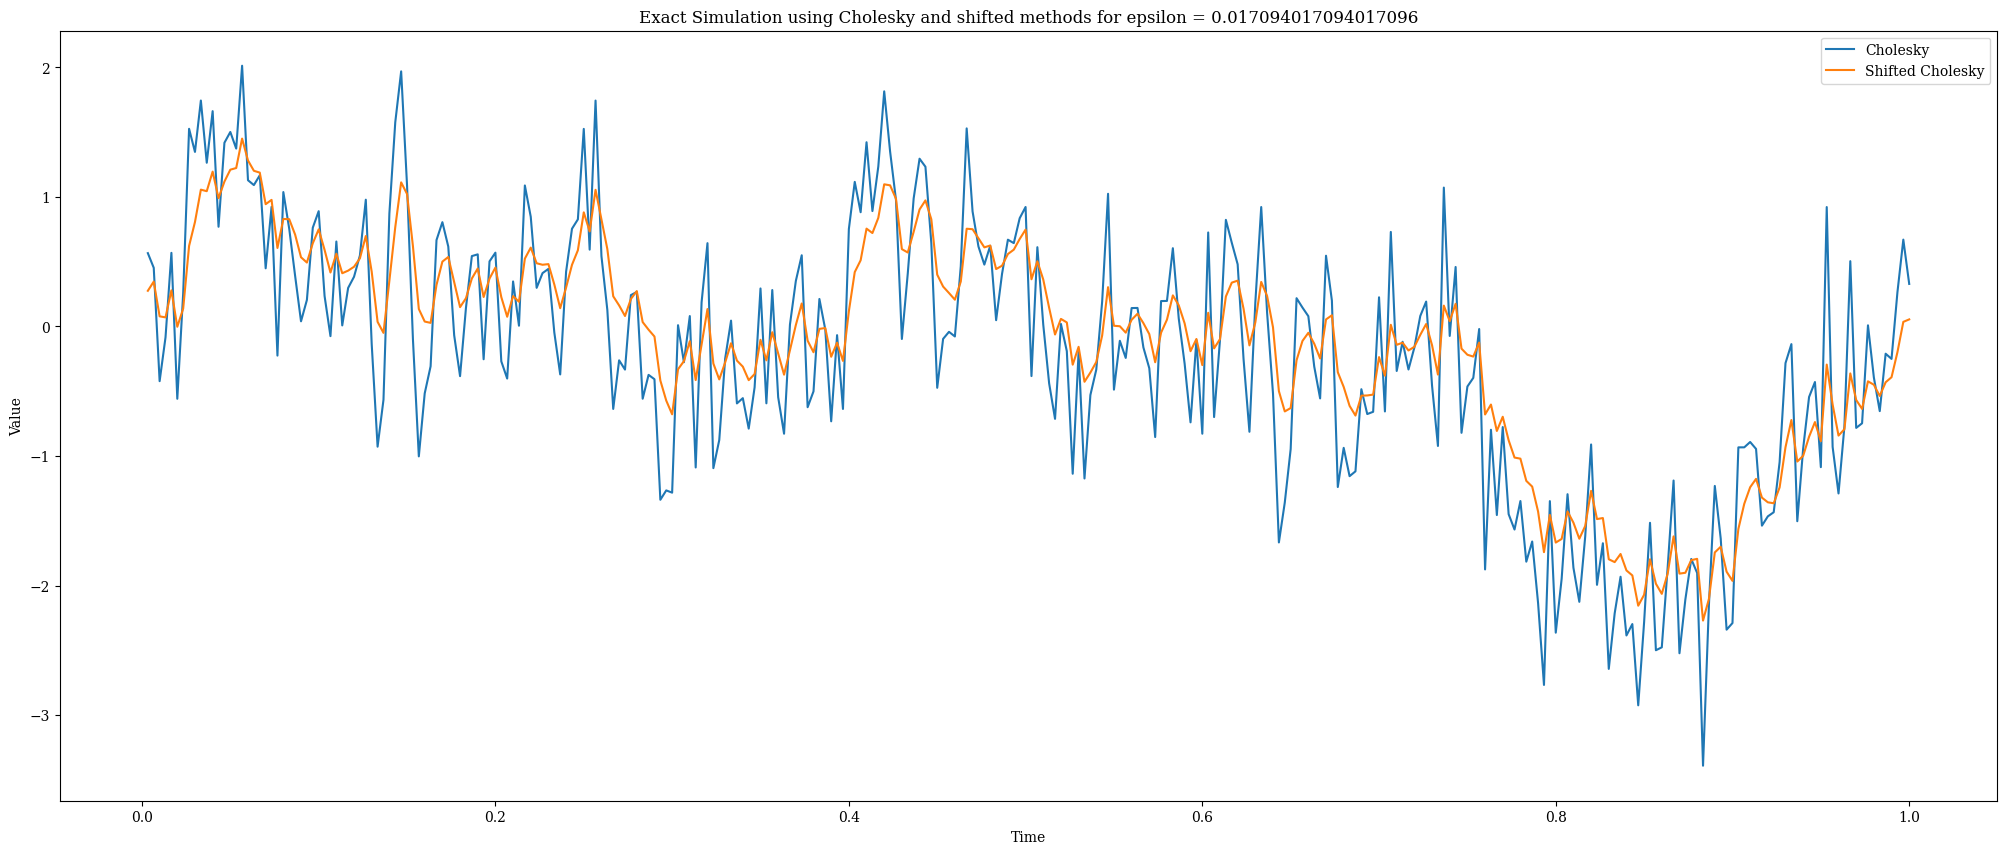

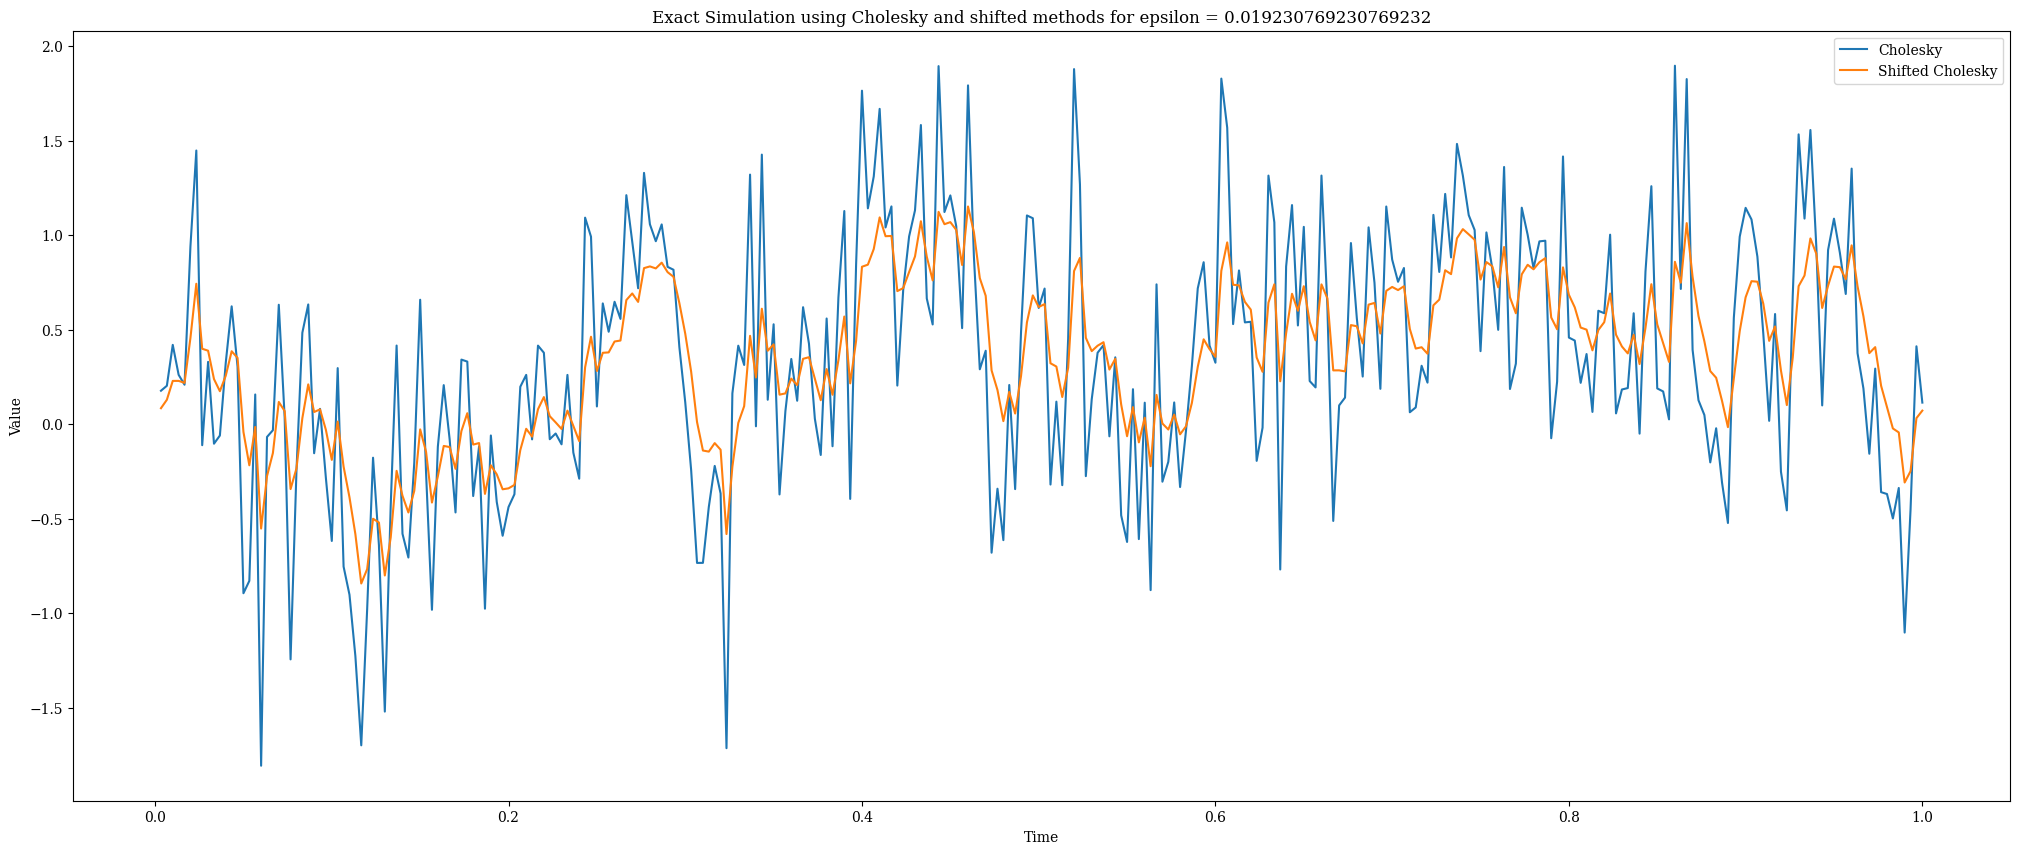

In [ ]:
import numpy as np
import scipy.special as sc
from scipy.special import gamma
import matplotlib.pyplot as plt

def kernel_covariance(s, u, v, H):
    alpha = H + 1/2
    result = v**2 * ((s**alpha)/(u)**(1-alpha)) * sc.hyp2f1(1, 1 - alpha, 1 + alpha, s/u) / (gamma(alpha) * gamma(1 + alpha))
    return result

def shifted_kernel_covariance(epsilon, s, u, v, H):
    alpha = H + 1/2
    u2 = u + epsilon
    result = v**2 * ((s**alpha)/(u2)**(1-alpha)) * sc.hyp2f1(1, 1 - alpha, 1 + alpha, s/u2) / (gamma(alpha) * gamma(1 + alpha))
    return result

def exact_simulation_chol_and_shift(epsilon, T, nsteps, v, H):
    t_values = np.linspace(T/nsteps, T, nsteps)
    dt = T/nsteps

    cov_matrix = np.zeros((nsteps, nsteps), dtype=np.float64)
    shifted_cov_matrix = np.zeros((nsteps, nsteps), dtype=np.float64)

    for i in range(nsteps):
        for j in range(i, nsteps):
            cov_matrix[i, j] = kernel_covariance(t_values[i], t_values[j], v, H)
            cov_matrix[j, i] = cov_matrix[i, j]
            shifted_cov_matrix[i, j] = shifted_kernel_covariance(epsilon, t_values[i], t_values[j], v, H)
            shifted_cov_matrix[j, i] = shifted_cov_matrix[i, j]

    L = np.linalg.cholesky(cov_matrix)
    L_shifted = np.linalg.cholesky(shifted_cov_matrix)

    Z = np.random.normal(0, 1, nsteps)

    X_chol = np.dot(L, Z)
    X_chol_shifted = np.dot(L_shifted, Z)

    return t_values, X_chol, X_chol_shifted

T = 1
nsteps = 300
v = 1
H = 0.14

for epsilon in np.linspace(0, 1/52, 10):
    result = exact_simulation_chol_and_shift(epsilon, T, nsteps, v, H)
    if result is not None:
        t_values, X_chol, X_chol_shifted = result
        plt.plot(t_values, X_chol, label='Cholesky')
        plt.plot(t_values, X_chol_shifted, label='Shifted Cholesky')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Exact Simulation using Cholesky and shifted methods for epsilon = {epsilon}')
        plt.legend()
        plt.show()
